In [25]:
# Built-in
import os
import math
import itertools
import multiprocessing
import statistics

# Analysis packages
import scanpy as sc
import anndata as ad
from adpbulk import ADPBulk
import numpy as np
import pandas as pd
import memento
from statsmodels.compat import lzip
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as scipystats
from sklearn.decomposition import PCA
from sklearn import manifold
import sklearn.cluster as clustering
from tslearn.clustering import KShape
import h5py

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.patheffects as path_effects
from pathlib import Path
import seaborn as sns
from adjustText import adjust_text

# Set number of cores to use
sc.settings.n_jobs = 8

sc.logging.print_header()

scanpy==1.10.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.0 scipy==1.13.1 pandas==1.5.3 scikit-learn==1.5.0 statsmodels==0.13.5 igraph==0.11.6 pynndescent==0.5.8


In [26]:
pd.set_option('display.max_columns', 40)

In [27]:
# Set autoreload settings. With this code,
# changing settings.py (see next cell) automatically loads the new settings in here too.
%load_ext autoreload
%autoreload 1

# Modify settings from this file (figure path, subsetting settings, etc)
# The file is located in this directory (settings.py)
%aimport settings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Overhead

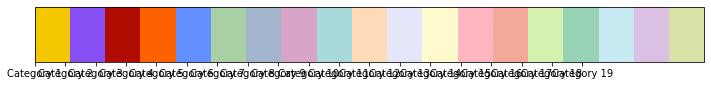

In [28]:
# Define the extended color list
colors_19 = [
    "#F4C700", "#8650F5", "#B00B00", "#FE6100", "#648FFF",
    "#A9CFA4", "#A3B5CC", "#D8A4C7", "#A8DADC", "#FFDAB9",
    "#E6E6FA", "#FFFACD", "#FFB6C1", "#F4A89A", "#D4F1B0",
    "#98D2B5", "#C7EAF2", "#DAC0E2", "#D9E3A8",
]

# Create a ListedColormap
custom_cmap = ListedColormap(colors_19)

# Display the colormap using a colorbar
fig, ax = plt.subplots(figsize=(12, 2))
fig.subplots_adjust(bottom=0.5)

# Create a colorbar with the custom cmap
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=custom_cmap), 
    cax=ax, orientation='horizontal', ticks=[]
)

# Use the colors as category labels
cbar.set_ticks([i / 22.0 for i in range(len(colors_19))])
cbar.set_ticklabels([f'Category {i + 1}' for i in range(len(colors_19))])

# Display the colorbar
plt.show()

In [29]:
cluster_colors = colors_19[0:5]
color_order = ['L5-PT','IT','CIN-PV','CIN-SST','CIN-VIP']

In [30]:
def extend_limits(t, buffer=0.02):
    lower = t[0]
    upper = t[1]
    extension = buffer * (upper - lower)
    return (lower - extension, upper + extension)
extend_limits((0,2))

(-0.04, 2.04)

In [31]:
adata = sc.read("post-wt-clustering-with-markers.h5ad")
adata

AnnData object with n_obs × n_vars = 264420 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden', 'id', 'name', 'color'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'name_colors', 'rank_genes_groups', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

In [32]:
dendro_ordered_cluster_ids = adata.uns['dendrogram_leiden']['categories_ordered']

In [33]:
drugs = ["none", "Ket", "Psilo"]
times = adata.uns["stage_order"]
clusters = ['0','1','2','3','4','5','6','7','8','9','10','12']
cluster_names = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT',
                 'Oligodendrocytes','L5/6-IT','Astrocytes','L5-PT','CIN-PV',
                 'OPC','CIN-SST','CIN-VIP']

In [34]:
lump_excitatory = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT','L5/6-IT','L5-PT']
lump_cin = ['CIN-PV','CIN-SST','CIN-VIP']

In [35]:
trt_drugs = drugs[1:]
trt_times = times[1:]

In [36]:
cluster_lookup = pd.DataFrame({'id':clusters, 'name':cluster_names})
cluster_lookup['id'] = pd.Categorical(cluster_lookup['id'], categories=dendro_ordered_cluster_ids, ordered=True)
cluster_lookup = cluster_lookup.sort_values('id')
cluster_lookup['name'] = pd.Categorical(cluster_lookup['name'], categories=cluster_lookup['name'], ordered=True)
cluster_lookup['color'] = adata.uns['name_colors']
cluster_lookup

,id,name,color
1,1,L6-CT,#A9CFA4
7,7,L5-PT,#F4C700
2,2,L4/5-IT,#8650F5
3,3,L4-IT,#4F19BE
0,0,L2/3-IT,#7662A0
5,5,L5/6-IT,#BA98FF
11,12,CIN-VIP,#648FFF
8,8,CIN-PV,#B00B00
10,10,CIN-SST,#FE6100
4,4,Oligodendrocytes,#A3B5CC


In [37]:
heatmap_idx = cluster_lookup['name'].to_list()
heatmap_cluster_labels = cluster_lookup.apply(lambda row: f"({row['id']}) {row['name']}", axis=1).to_list()

# Cell counts for the paper

## Before we dropped a bunch of cell types

In [4]:
original_adata = sc.read(os.path.join(settings.data_path, 'post-wt-clustering.h5ad'))

In [13]:
# cell counts
for drug in drugs:
    print(drug, original_adata[original_adata.obs['drug'] == drug].shape[0])

none 56693
Ket 119815
Psilo 122685


In [15]:
# cell counts for the clusters we kept
for drug in drugs:
    print(drug, original_adata[(original_adata.obs['drug'] == drug) &
                               (original_adata.obs['leiden']).isin(clusters)].shape[0])

none 49963
Ket 106397
Psilo 108060


In [16]:
# cell depth
original_adata.obs.head()

,time,time_str,drug,sex,approx_reads_per_cell,date,label,batch,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,n_counts,n_genes,doublet_score,log10_gene_counts,log10_UMI_counts,percent_mito,percent_ribo,leiden
AAACCCAAGTAGACAT-1-0h_none_F_346,0,0,none,F,25K,4/5/22,0h_none_F_346,6155,0,3991,8.292048,17264.0,9.756436,17264.0,4020,0.018405,3.604334,4.245093,0.002502,0.001479,1
AAACCCAAGTATCCTG-1-0h_none_F_346,0,0,none,F,25K,4/5/22,0h_none_F_346,6155,0,3357,8.119101,8862.0,9.089641,8862.0,3383,0.007324,3.529302,3.968296,0.000215,0.002689,8
AAACCCACAAGGATGC-1-0h_none_F_346,0,0,none,F,25K,4/5/22,0h_none_F_346,6155,0,3930,8.276649,12117.0,9.402448,12120.0,3951,0.011114,3.596927,4.089269,0.000244,0.001547,11
AAACCCACAATTAGGA-1-0h_none_F_346,0,0,none,F,25K,4/5/22,0h_none_F_346,6155,0,4313,8.369621,18289.0,9.814110,18289.0,4334,0.051054,3.636889,4.274758,0.000212,0.001115,0
AAACCCACAGCCGTCA-1-0h_none_F_346,0,0,none,F,25K,4/5/22,0h_none_F_346,6155,0,1375,7.226936,2398.0,7.782807,2398.0,1392,0.008281,3.143639,3.389698,0.003669,0.004892,13


In [17]:
cell_depth_stats = original_adata.obs.groupby(['label','drug'])['n_counts'].mean().to_frame().dropna().reset_index()
cell_depth_stats = cell_depth_stats.groupby('drug')['n_counts'].describe()
cell_depth_stats.to_csv('cell_depth_stats.csv')
cell_depth_stats

,count,mean,std,min,25%,50%,75%,max
drug,,,,,,,,
Ket,17.0,9023.309570,1507.969604,6656.219238,7705.264648,9033.205078,9795.277344,11874.705078
Psilo,17.0,8686.664062,1053.999390,6980.226562,8029.225098,8656.205078,9324.775391,10816.413086
none,8.0,8422.902344,852.984436,7136.707520,7887.297363,8394.766602,8895.232910,9833.543945


In [18]:
del original_adata

# Inspect read depth

In [35]:
just_one = sc.read_10x_h5('/nfs/turbo/umms-kykwan/raw_data/CL_Files/6128-CL/10x_analysis_6128-CL/Sample_6128-CL-1-GEX_GAATTGGTTA-CTACTAGAGT/filtered_feature_bc_matrix.h5')
just_one.var_names_make_unique()
just_one.shape

/home/etofarre/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(7475, 32285)

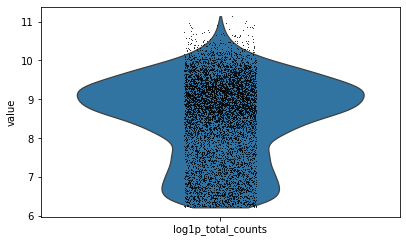

(7475, 32285)

In [36]:
sc.pp.calculate_qc_metrics(just_one, inplace=True)
sc.pl.violin(just_one, 'log1p_total_counts')
just_one.shape

In [37]:
# remove genes with fewer than 5 total counts
sc.pp.filter_genes(just_one, min_counts=5, inplace=True)
# remove cells with fewer than 5 total counts (The actual threshold will be calculated again)
sc.pp.filter_cells(just_one, min_counts=5)

sc.pp.filter_cells(just_one, min_genes=3)
sc.pp.filter_genes(just_one, min_cells=3)

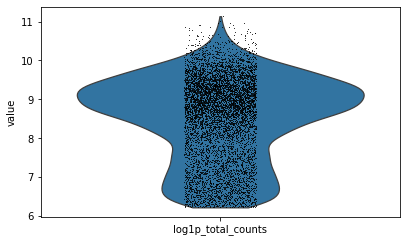

(7475, 21242)

In [38]:
sc.pp.calculate_qc_metrics(just_one, inplace=True)
sc.pl.violin(just_one, 'log1p_total_counts')
just_one.shape

In [28]:
!rm -f /home/etofarre/.cache/scikit-image/0.18.3/data/README.txt

/home/etofarre/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scrublet/core.py:337: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  AnnData(
/home/etofarre/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scrublet/core.py:337: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  AnnData(


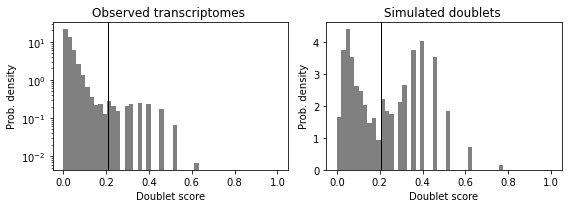

In [30]:
sc.pp.scrublet(just_one)
sc.pl.scrublet_score_distribution(just_one)

In [32]:
just_one.obs['predicted_doublet'].mean()

0.037190635451505014

In [33]:
just_one = just_one[~just_one.obs['predicted_doublet']]

/home/etofarre/.local/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


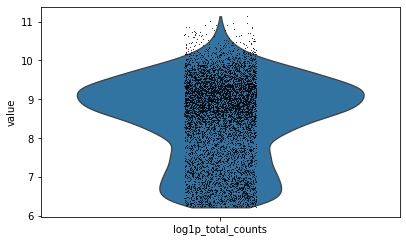

(7197, 32285)

In [34]:
sc.pp.calculate_qc_metrics(just_one, inplace=True)
sc.pl.violin(just_one, 'log1p_total_counts')
just_one.shape

In [39]:
del just_one

## Cell type counts by treatment group

In [18]:
adata.obs.head()

,time,time_str,drug,sex,approx_reads_per_cell,date,label,batch,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,n_counts,n_genes,doublet_score,log10_gene_counts,log10_UMI_counts,percent_mito,percent_ribo,leiden,id,name,color
index,,,,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGTAGACAT-1-0h_none_F_346,0,0,none,F,25K,4/5/22,0h_none_F_346,6155,0,3991,8.292048,17264.0,9.756436,17264.0,4020,0.018405,3.604334,4.245093,0.002502,0.001479,1,1,L6-CT,#A9CFA4
AAACCCAAGTATCCTG-1-0h_none_F_346,0,0,none,F,25K,4/5/22,0h_none_F_346,6155,0,3357,8.119101,8862.0,9.089641,8862.0,3383,0.007324,3.529302,3.968296,0.000215,0.002689,8,8,CIN-PV,#B00B00
AAACCCACAATTAGGA-1-0h_none_F_346,0,0,none,F,25K,4/5/22,0h_none_F_346,6155,0,4313,8.369621,18289.0,9.814110,18289.0,4334,0.051054,3.636889,4.274758,0.000212,0.001115,0,0,L2/3-IT,#8650F5
AAACCCACAGTCGGAA-1-0h_none_F_346,0,0,none,F,25K,4/5/22,0h_none_F_346,6155,0,613,6.419995,1387.0,7.235619,1387.0,615,0.015844,2.788875,3.147985,0.000000,0.000711,3,3,L4-IT,#8650F5
AAACCCAGTCATATGC-1-0h_none_F_346,0,0,none,F,25K,4/5/22,0h_none_F_346,6155,0,4361,8.380686,16079.0,9.685331,16080.0,4387,0.035619,3.642168,4.230194,0.000000,0.002001,0,0,L2/3-IT,#8650F5


In [49]:
with pd.ExcelWriter('treatment_samples_report.xlsx', mode='w') as excel_writer:
    for drug in trt_drugs:
        treatment_group = adata[adata.obs['drug'].isin(['none',drug])].obs.groupby(['name','time'])
        cell_counts = treatment_group.size().rename('cell_count').to_frame().reset_index()
        sample_counts = treatment_group['label'].nunique().rename('n_samples').to_frame().reset_index()
        treatment_report = cell_counts.merge(sample_counts, on=['name','time'], how='inner')
        
        treatment_report.to_excel(excel_writer, sheet_name=drug, index=False)

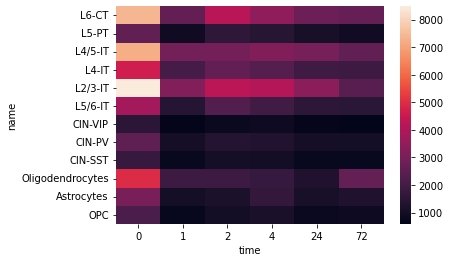

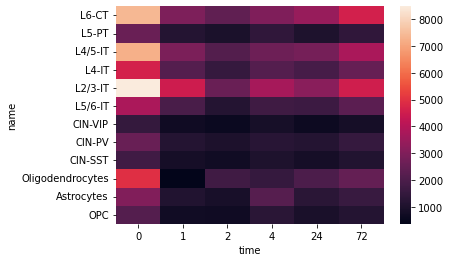

In [16]:
with pd.ExcelWriter('cell_type_counts_by_treatment.xlsx', mode='w') as excel_writer:
    for drug in trt_drugs:
        df = adata[adata.obs['drug'].isin(['none',drug])].obs.groupby(['name','time']).size().to_frame()
        df = df.reset_index()
        df.columns = ['name','time','cell_count']
        df = df.pivot(index='name', columns='time', values='cell_count')
        
        sns.heatmap(df)
        plt.show()

        df.to_excel(excel_writer, sheet_name=drug)

this really looks like it will correlate with the number of DEGs we get in our volcanos. should we have normalized everything by cell count?

# Get Memento results

In [38]:
def process_combination(drug, cluster, time):
    subset_memento = pd.read_excel(
        os.path.join(settings.data_path, f"memento_initial_DE_{drug}_{time}h.xlsx"),
        sheet_name=f'Cluster {cluster}',
        index_col=0
    )
    subset_memento = subset_memento.reset_index(drop=True)
    subset_memento = subset_memento[['gene', 'de_coef', 'de_se', 'de_pval', 'de_pval_adj']]
    
    subset_memento['drug'] = drug
    subset_memento['cluster'] = cluster
    subset_memento['time'] = time
    return subset_memento

In [39]:
from tqdm.contrib.itertools import product as progressbar_product
combination_mementos = [
    process_combination(drug,cluster,time) 
    for drug,cluster,time
    in progressbar_product(trt_drugs,clusters,trt_times)
#     if not (cluster=='4' and drug=='Psilo')
]
memento_full = pd.concat(combination_mementos)
print(memento_full.shape)
memento_full.head()

  0%|          | 0/120 [00:00<?, ?it/s]

(1412444, 8)


,gene,de_coef,de_se,de_pval,de_pval_adj,drug,cluster,time
0,Prrc2b,0.162677,0.015609,4.414582e-10,0.000005,Ket,0,1
1,Slc4a4,-0.124186,0.011237,1.556089e-09,0.000010,Ket,0,1
2,Map4,-0.179530,0.017800,4.780192e-08,0.000198,Ket,0,1
3,Maml3,0.218901,0.012652,7.577917e-08,0.000236,Ket,0,1
4,Btg2,-0.846753,0.069693,6.139451e-06,0.001071,Ket,0,1


In [40]:
de_overlaps_1000 = memento_full.copy()
de_overlaps_1000 = de_overlaps_1000.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
de_overlaps_1000 = de_overlaps_1000[['gene','drug','time','name','de_coef','de_pval_adj']]
de_overlaps_1000 = de_overlaps_1000.sort_values('name')
de_overlaps_1000_groups = de_overlaps_1000.groupby(['drug','name','time']) 
de_overlaps_1000 = {}
for name, group in de_overlaps_1000_groups:
    de_overlaps_1000[name] = group.sort_values('de_pval_adj', ascending=True) \
         .reset_index() \
         .loc[0:999]
    
del de_overlaps_1000_groups
de_overlaps_1000[('Psilo','Astrocytes',1)].head()

,index,gene,drug,time,name,de_coef,de_pval_adj
0,1062703,Zbtb16,Psilo,1,Astrocytes,1.452664,4.384558e-08
1,1062704,Fkbp5,Psilo,1,Astrocytes,2.318690,4.672225e-06
2,1062705,Rmst,Psilo,1,Astrocytes,0.330035,2.603443e-04
3,1062707,Lhfp,Psilo,1,Astrocytes,0.934302,1.419561e-03
4,1062706,Nr3c2,Psilo,1,Astrocytes,-0.548093,1.419561e-03


In [41]:
def non_directional_cluster_relation_matrix(drug, time, distance_function):
    heatmap_idx = cluster_lookup['name'].to_list()
    distances = np.zeros((len(heatmap_idx), len(heatmap_idx)))
    for i,i_name in enumerate(heatmap_idx):
        for j,j_name in enumerate(heatmap_idx):
            try:
                A = de_overlaps_1000[(drug,i_name, time)]
                B = de_overlaps_1000[(drug,j_name, time)]
            except KeyError:
                distances[i][j] = np.inf
                continue
            if i == j:
                distances[i][j] = None
                continue
            
            distances[i][j] = distance_function(A, B)
    return distances

In [42]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def euclidean_distance_logFC(A, B):
    A_df = A[['gene', 'de_coef']]
    B_df = B[['gene', 'de_coef']]
    union_folds = A_df.merge(B_df, on='gene', how='outer').fillna(0)
    A_folds = union_folds['de_coef_x'].to_numpy()
    B_folds = union_folds['de_coef_y'].to_numpy()
    return euclidean_distance(A_folds, B_folds)

def cosine_distance_logFC(A, B):
    A_df = A[['gene', 'de_coef']]
    B_df = B[['gene', 'de_coef']]
    union_folds = A_df.merge(B_df, on='gene', how='outer').fillna(0)
    A_folds = union_folds['de_coef_x'].to_numpy()
    B_folds = union_folds['de_coef_y'].to_numpy()
    return cosine_distance(A_folds, B_folds)

In [43]:
intercluster_distances = np.stack([non_directional_cluster_relation_matrix('Psilo', time, cosine_distance_logFC) for time in trt_times])
intercluster_distances.shape

(5, 12, 12)

In [44]:
list(enumerate(heatmap_idx))

[(0, 'L6-CT'),
 (1, 'L5-PT'),
 (2, 'L4/5-IT'),
 (3, 'L4-IT'),
 (4, 'L2/3-IT'),
 (5, 'L5/6-IT'),
 (6, 'CIN-VIP'),
 (7, 'CIN-PV'),
 (8, 'CIN-SST'),
 (9, 'Oligodendrocytes'),
 (10, 'Astrocytes'),
 (11, 'OPC')]

In [45]:
def lumps_numbers_to_names(lumps):
    return [[heatmap_idx[celltype] for celltype in lump] for lump in lumps ]

def distance_bw2_lumps(lump_a, lump_b):
    return np.mean(np.concatenate(([intercluster_distances[:,i,j] for i, j in itertools.product(lump_a, lump_b)])))

def mBCSS(lumps):
    between_cluster_distances = []
    for lump_a, lump_b in itertools.combinations_with_replacement(lumps, 2):
        # get one value for each lump pair
        if lump_a == lump_b:
            continue
        d = distance_bw2_lumps(lump_a, lump_b) # should be a mean?
        between_cluster_distances.append(d)
    
    return sum([d**2 for d in between_cluster_distances])

def distance_within_lump(lump):
    return np.nansum(intercluster_distances[:,lump,:][:,:,lump] ** 2, ) / 2

def mWCSS(lumps):
    return sum([distance_within_lump(lump) for lump in lumps])

def calinski_harabasz_index(lumps):
    n = sum([len(l) for l in lumps])
    k = len(lumps)
    mCHI = (mBCSS(lumps) / (k - 1)) / (mWCSS(lumps) / (n - k))
    return {
        'mCHI':mCHI,
        'lumps':lumps_numbers_to_names(lumps),
        'components':f'mBCSS={mBCSS(lumps):.2f} , mWCSS={mWCSS(lumps):.2f}',
        'dof':f'n={n} k={k}'
    }

In [46]:
calinski_harabasz_index([[1], [0,2,3,4,5], [6,7,8]])

{'mCHI': 0.20255482414401255,
 'lumps': [['L5-PT'],
  ['L6-CT', 'L4/5-IT', 'L4-IT', 'L2/3-IT', 'L5/6-IT'],
  ['CIN-VIP', 'CIN-PV', 'CIN-SST']],
 'components': 'mBCSS=1.25 , mWCSS=18.57',
 'dof': 'n=9 k=3'}

In [47]:
calinski_harabasz_index([[0],[1],[2,3,4,5],[6,7,8]])

{'mCHI': 0.2784990604433013,
 'lumps': [['L6-CT'],
  ['L5-PT'],
  ['L4/5-IT', 'L4-IT', 'L2/3-IT', 'L5/6-IT'],
  ['CIN-VIP', 'CIN-PV', 'CIN-SST']],
 'components': 'mBCSS=2.26 , mWCSS=13.52',
 'dof': 'n=9 k=4'}

In [48]:
calinski_harabasz_index([[0, 1],[2,3,4,5],[6,7,8]])

{'mCHI': 0.2392689006233876,
 'lumps': [['L6-CT', 'L5-PT'],
  ['L4/5-IT', 'L4-IT', 'L2/3-IT', 'L5/6-IT'],
  ['CIN-VIP', 'CIN-PV', 'CIN-SST']],
 'components': 'mBCSS=1.21 , mWCSS=15.12',
 'dof': 'n=9 k=3'}

In [49]:
calinski_harabasz_index([[0,1,2,3,4,5],[6,7,8]])

{'mCHI': 0.12707307328326276,
 'lumps': [['L6-CT', 'L5-PT', 'L4/5-IT', 'L4-IT', 'L2/3-IT', 'L5/6-IT'],
  ['CIN-VIP', 'CIN-PV', 'CIN-SST']],
 'components': 'mBCSS=0.47 , mWCSS=25.91',
 'dof': 'n=9 k=2'}

(array([ 78., 130., 212., 152.,  28.,  28.,  10.,   0.,   4.,  18.]),
 array([ 83.30903615, 155.31558142, 227.32212669, 299.32867195,
        371.33521722, 443.34176249, 515.34830775, 587.35485302,
        659.36139828, 731.36794355, 803.37448882]),
 <BarContainer object of 10 artists>)

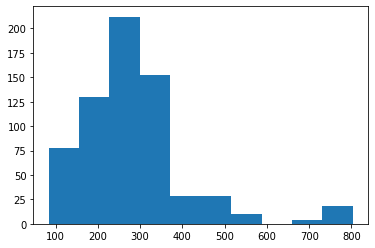

In [26]:
intercluster_square_distances_quantiles = intercluster_distances.flatten() ** 2
intercluster_square_distances_quantiles = np.sort(intercluster_square_distances_quantiles)
intercluster_square_distances_quantiles = intercluster_square_distances_quantiles[~np.isnan(intercluster_square_distances_quantiles)]
plt.hist(intercluster_square_distances_quantiles)

In [27]:
# other mWCMS
ocss_distances = []
lumps = [set([1]), set([0,2,3,4,5]), set([6,7,8])]
for cluster_a,cluster_b in itertools.product(range(len(heatmap_idx)), range(len(heatmap_idx))):
    if cluster_a==cluster_b or any([cluster_a in lump and cluster_b in lump for lump in lumps]):
        continue
    ocss_distances += list(intercluster_distances[:, cluster_a, cluster_b])

In [28]:
np.mean(np.array(ocss_distances) ** 2)

305.8645733778028

In [54]:
intercluster_distances[:,[0,2,3,4,5],:][:,:,[0,2,3,4,5]].shape

(5, 5, 5)

In [57]:
# IT MWCSS
# excitatory_mwcss_test_statistic = np.nanmean(intercluster_distances[:,0:6,0:6] ** 2, )
it_mwcss_test_statistic = np.nanmean(intercluster_distances[:,[0,2,3,4,5],:][:,:,[0,2,3,4,5]] ** 2, )
it_mwcss_p_val = np.mean(intercluster_square_distances_quantiles < it_mwcss_test_statistic)
it_mwcss_test_statistic, it_mwcss_p_val

(167.04418059926036, 0.17575757575757575)

In [58]:
# inhibitory MWCSS
inhibitory_mwcss_test_statistic = np.nanmean(intercluster_distances[:, 6:9, 6:9] ** 2)
inhibitory_mwcss_p_val = np.mean(intercluster_square_distances_quantiles < inhibitory_mwcss_test_statistic)
inhibitory_mwcss_test_statistic, inhibitory_mwcss_p_val

(254.80351422657202, 0.42727272727272725)

In [51]:
# baseline MCSS (both within and outside cluster)
np.nanmean(intercluster_distances ** 2)

282.51022329842226

# ANOVA for number of DE genes

Highlighting how the Excitatory and CIN cell type lumps show the most DE

In [16]:
de_overlaps_significant = memento_full.copy()
de_overlaps_significant = de_overlaps_significant.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
de_overlaps_significant = de_overlaps_significant[['gene','drug','time','name','de_coef','de_pval_adj']]
de_overlaps_significant = de_overlaps_significant.sort_values('name')
de_overlaps_significant = de_overlaps_significant.groupby(['drug','name','time']).size().rename('de_count')
de_overlaps_significant = de_overlaps_significant.to_frame().reset_index()
de_overlaps_significant.head()

,drug,name,time,de_count
0,Ket,L6-CT,1,11895
1,Ket,L6-CT,2,11976
2,Ket,L6-CT,4,12006
3,Ket,L6-CT,24,11941
4,Ket,L6-CT,72,11890


In [60]:
de_overlaps_significant['lump'] = de_overlaps_significant['name'].apply(
    lambda x: 'excitatory' if x in lump_excitatory else ('cin' if x in lump_cin else 'none')
)
de_overlaps_significant

,drug,name,time,de_count,lump
0,Ket,L6-CT,1,11895,excitatory
1,Ket,L6-CT,2,11976,excitatory
2,Ket,L6-CT,4,12006,excitatory
3,Ket,L6-CT,24,11941,excitatory
4,Ket,L6-CT,72,11890,excitatory
...,...,...,...,...,...
115,Psilo,OPC,1,10145,none
116,Psilo,OPC,2,10868,none
117,Psilo,OPC,4,10659,none
118,Psilo,OPC,24,10706,none


Send to R

In [61]:
psilo_de_counts = de_overlaps_significant[de_overlaps_significant['drug'] == 'Psilo']
psilo_de_counts.to_csv(
    'psilo_de_counts_by_cell_type.csv', index=False
)

## Linear Regression



In [62]:
import statsmodels.formula.api as smf

In [66]:
mod = smf.ols('de_count ~ C(lump,Treatment("none")) + time', data=psilo_de_counts)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               de_count   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     83.65
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           1.12e-20
Time:                        17:15:21   Log-Likelihood:                -451.08
No. Observations:                  60   AIC:                             910.2
Df Residuals:                      56   BIC:                             918.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                 1.016e+04    127.383     79.727      0.000    9900.728    1.04e+04
C(lump, Treatment("none"))[T.cin]         1841.8667    168.357     10.940      0.000    1504.608    2179.125
C(lump, Treatment("none"))[T.excitatory]  2284.0667    145.801     15.666      0.000    1991.992    2576.141
time                                        -0.8692      2.200     -0.395      0.694      -5.277       3.538
==============================================================================
Omnibus:                        4.960   Durbin-Watson:                   0.704
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.605
Skew:                          -0.678   Prob(JB):                        0.100
Kurtosis:                       2.980   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
res.pvalues

Intercept                                   2.400499e-59
C(lump, Treatment("none"))[T.cin]           1.592892e-15
C(lump, Treatment("none"))[T.excitatory]    3.995772e-22
time                                        6.942971e-01
dtype: float64

## ANOVA

since theres no time, ANOVA should be simple and interpreatble and harmonized with the other tests Clara performed

In [67]:
anova_samples = [ 
    psilo_de_counts.query(f'lump == "{lump}"')['de_count'].to_list() 
    for lump in ['none','excitatory','cin'] 
]

In [70]:
f_oneway(*anova_samples)

F_onewayResult(statistic=127.28605017099886, pvalue=9.462684745022133e-22)

# Figure 6 - Gene clusterings

In [47]:
this_figure_dir = f'{settings.fig_path}/figure_6/fig_6_separate_bucketing'
os.makedirs(this_figure_dir, exist_ok=True)

In [48]:
# 0-1 inverse link functions
def logit(x):
    return 1 / (1 + np.exp(-x))

def cloglog(x):
    return 1 - np.exp(-np.exp(x))

# distance functions
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def cosine_distance(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

## CIN combined

In [49]:
cin_gene_progression = pd.DataFrame()
cin_significant_genes = set()
for time in trt_times:
    deg_results = pd.read_csv(os.path.join(settings.fig_path, 
                             f'figure_5/pseudobulk_clusters_counts/DEGs_CIN_{time}h_Psilo.csv'), 
                index_col=0)
    
    sig_results = deg_results[deg_results['FDR'] < 0.05].index.to_list()
    cin_significant_genes.update(set(sig_results)) 
    
    deg_results_series = deg_results['logFC'].rename(f'{time}h')
    cin_gene_progression = cin_gene_progression.join(deg_results_series, how='outer')

cin_gene_progression = cin_gene_progression.dropna()
pivot_cols = cin_gene_progression.columns

In [51]:
len(cin_significant_genes)

3044

In [52]:
cin_significant_gene_progression = cin_gene_progression.loc[cin_gene_progression.index.isin(cin_significant_genes)].copy()
cin_significant_gene_progression

,1h,2h,4h,24h,72h
0610030E20Rik,-0.492896,0.073616,-0.139450,0.035941,-0.254730
0610043K17Rik,-0.279517,0.228600,0.293762,-0.046003,-0.472453
1110008P14Rik,0.931890,0.012202,-0.162473,0.120335,0.140015
1110017D15Rik,-0.389174,-0.198722,-0.393501,-0.496028,-0.587892
1110032A03Rik,-0.258205,-0.187492,0.120077,0.208867,-0.436533
...,...,...,...,...,...
Zswim8,0.572511,-0.029266,-0.168740,0.033558,0.229561
Zup1,-0.390749,0.010462,-0.005944,0.056229,-0.142614
Zwint,0.435519,0.097039,-0.069796,0.359861,0.465942
Zyx,0.641607,0.247851,0.007734,0.545425,0.183665


# Bootstrapping memento results - testing

In [17]:
this_figure_dir = f'{settings.fig_path}/figure_7'
os.makedirs(this_figure_dir, exist_ok=True)

In [115]:
de_overlaps_significant = memento_full.copy()
de_overlaps_significant = de_overlaps_significant.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
de_overlaps_significant = de_overlaps_significant.sort_values('name')
de_overlaps_significant_groups = de_overlaps_significant.groupby(['drug','name','time']) 
de_overlaps_significant = {}
for name, group in de_overlaps_significant_groups:
    de_overlaps_significant[name] = group.sort_values('de_pval_adj', ascending=True) \
         .reset_index()
    
del de_overlaps_significant_groups
# de_overlaps_significant[('Ket','Astrocytes',1)]
# [df.shape[0] for key,df in de_overlaps_significant.items()]

In [19]:
len(de_overlaps_significant.keys())

120

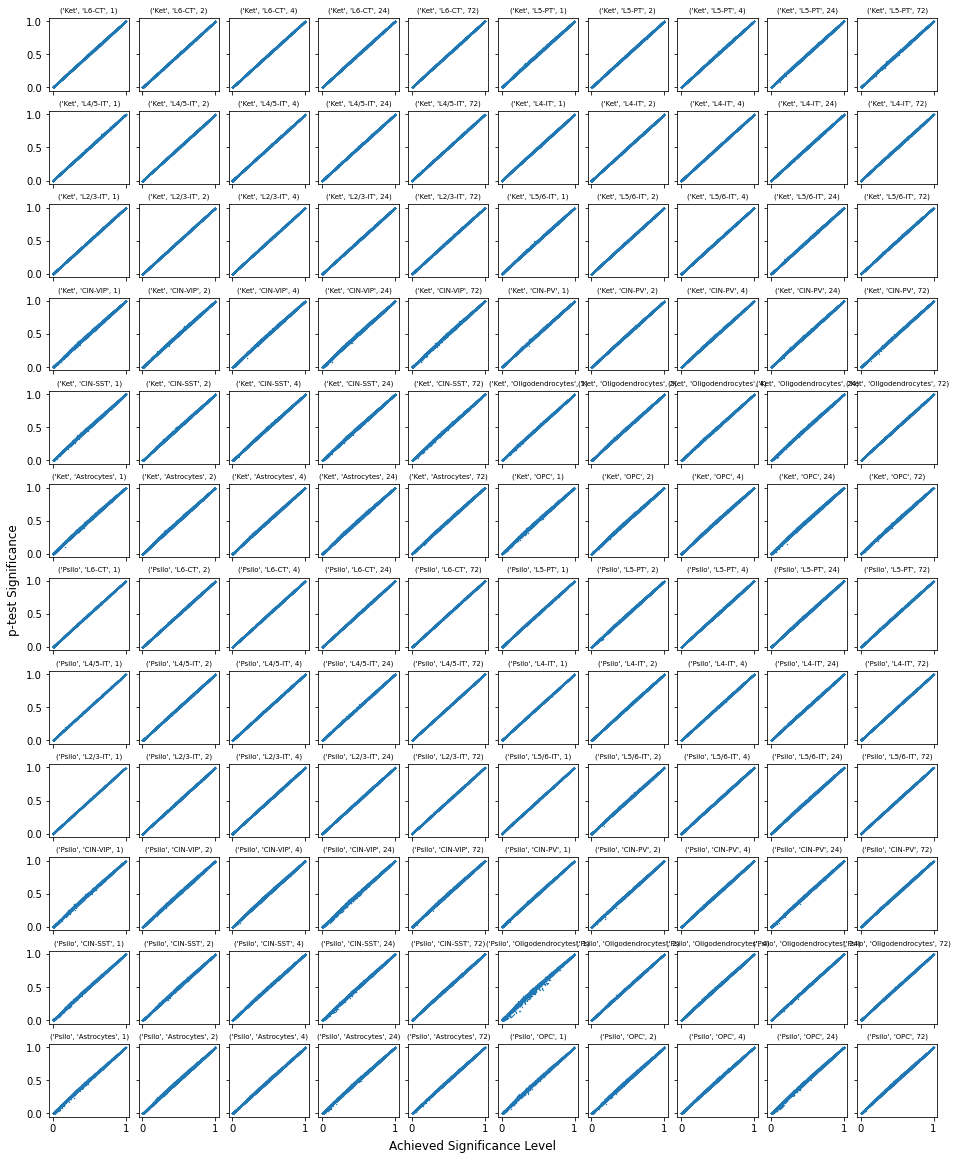

In [21]:
fig, axes = plt.subplots(12, 10, figsize=(13,16), layout='constrained',
                        sharex=True, sharey=True)

for ax, k in zip(axes.flatten(), de_overlaps_significant.keys()):
    tdf = de_overlaps_significant[k].copy()
    tdf['my_pval'] = 2 * scipystats.norm.sf(np.abs((tdf['de_coef'] - 0) / tdf['de_se']))
    sns.scatterplot(
        data=tdf, x='de_pval', y='my_pval',
        linewidth=0, s=2,
        ax=ax
    )
    ax.set_title(str(k), fontsize=7)
    ax.set(xlabel='', ylabel='')
    
fig.supxlabel('Achieved Significance Level')
fig.supylabel('p-test Significance')

plt.savefig(f'{this_figure_dir}/memento_asl_vs_ptests.png', dpi=600)
plt.savefig(f'{this_figure_dir}/memento_asl_vs_ptests.pdf', dpi=600)

# Bootstrap error bars for figure 7

In [108]:
this_figure_dir = f'{settings.fig_path}/figure_7'
os.makedirs(this_figure_dir, exist_ok=True)

In [109]:
def process_IT_combination(drug, time):
    combination_memento = pd.read_excel(
        os.path.join(f'{settings.fig_path}/figure_4', f"memento_DE_{drug}_{time}h.xlsx"),
    )
    combination_memento = combination_memento[['gene', 'de_coef', 'de_se', 'de_pval', 'de_pval_adj']]
    
    combination_memento['drug'] = drug
    combination_memento['time'] = time
    return combination_memento

from tqdm.contrib.itertools import product as progressbar_product
combination_mementos = [
    process_IT_combination(drug,time) 
    for drug,time
    in progressbar_product(trt_drugs,trt_times)
]
memento_IT = pd.concat(combination_mementos)
print(memento_IT.shape)
memento_IT.head()

  0%|          | 0/10 [00:00<?, ?it/s]

(126472, 7)


,gene,de_coef,de_se,de_pval,de_pval_adj,drug,time
0,Lpgat1,0.123609,0.008061,1.527522e-10,0.000002,Ket,1
1,Mkx,-0.108052,0.006298,2.079828e-09,0.000013,Ket,1
2,Lrrc49,0.152214,0.009209,5.000465e-09,0.000016,Ket,1
3,Tesc,0.220526,0.025597,4.714644e-09,0.000016,Ket,1
4,Mapk11,0.208848,0.015645,9.215292e-09,0.000023,Ket,1


In [110]:
de_overlaps_significant_IT_lump = memento_IT.copy()
de_overlaps_significant_IT_lump_groups = de_overlaps_significant_IT_lump.groupby(['drug','time']) 
de_overlaps_significant_IT_lump = {}
for name, group in de_overlaps_significant_IT_lump_groups:
    de_overlaps_significant_IT_lump[name] = group.sort_values('de_pval_adj', ascending=True) \
         .reset_index()
    
del de_overlaps_significant_IT_lump_groups
de_overlaps_significant_IT_lump[('Ket',1)]

,index,gene,de_coef,de_se,de_pval,de_pval_adj,drug,time
0,0,Lpgat1,0.123609,0.008061,1.527522e-10,0.000002,Ket,1
1,1,Mkx,-0.108052,0.006298,2.079828e-09,0.000013,Ket,1
2,2,Lrrc49,0.152214,0.009209,5.000465e-09,0.000016,Ket,1
3,3,Tesc,0.220526,0.025597,4.714644e-09,0.000016,Ket,1
4,4,Mapk11,0.208848,0.015645,9.215292e-09,0.000023,Ket,1
...,...,...,...,...,...,...,...,...
12603,12603,Pter,-0.000338,0.085389,9.964007e-01,0.996717,Ket,1
12604,12604,Phrf1,-0.000074,0.019757,9.966007e-01,0.996838,Ket,1
12605,12605,Zfp982,-0.000321,0.078416,9.968006e-01,0.996959,Ket,1
12606,12606,Kifc5b,-0.000163,0.055654,9.976005e-01,0.997680,Ket,1


In [198]:
def cosine_similarity(A, B, value_column='de_coef'):
    A_df = A[['gene', value_column]]
    B_df = B[['gene', value_column]]
    union_folds = A_df.merge(B_df, on='gene', how='outer').fillna(0)
    A_folds = union_folds[f'{value_column}_x'].to_numpy()
    B_folds = union_folds[f'{value_column}_y'].to_numpy()
    return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))

In [199]:
def significant_entries(df, significance_column='de_pval_adj', significance_threshold=0.05):
    return df[df[significance_column] < significance_threshold]

In [220]:
def similarity_error(full_psilo_set, full_ket_set, num_bootstraps=10):
    similarities = np.zeros(shape=num_bootstraps)
    rng = np.random.default_rng(2024)
    for i in range(num_bootstraps):
        psilo = full_psilo_set.copy()
        psilo['simulation_de_mean'] = rng.normal(loc=psilo['de_coef'], scale=psilo['de_se'])
        psilo['simulation_pval'] = 2 * scipystats.norm.sf(np.abs((psilo['simulation_de_mean'] - 0) / psilo['de_se']))
        _, psilo['simulation_padj'], _, _ = multipletests(
            psilo["simulation_pval"], alpha=0.05, method='fdr_bh'
        )
        
        ket = full_ket_set.copy()
        ket['simulation_de_mean'] = rng.normal(loc=ket['de_coef'], scale=ket['de_se'])
        ket['simulation_pval'] = 2 * scipystats.norm.sf(np.abs((ket['simulation_de_mean'] - 0) / ket['de_se']))
        _, ket['simulation_padj'], _, _ = multipletests(
            ket["simulation_pval"], alpha=0.05, method='fdr_bh'
        )
        
        similarities[i] = cosine_similarity(
            significant_entries(psilo, significance_column='simulation_padj'),
            significant_entries(ket, significance_column='simulation_padj')
        )
    
#     print(np.nanquantile(similarities, [0.025, 0.5, 0.975]))
    return [np.std(similarities)] + list(np.nanquantile(similarities, [0.025, 0.975]))

In [197]:
scipystats.norm.sf(2, )

0.022750131948179195

(array([6.000e+00, 1.070e+02, 1.031e+03, 4.950e+03, 4.842e+03, 1.045e+03,
        2.150e+02, 5.300e+01, 1.100e+01, 2.000e+00]),
 array([-45.45250276, -35.44793863, -25.44337449, -15.43881036,
         -5.43424622,   4.57031792,  14.57488205,  24.57944619,
         34.58401032,  44.58857446,  54.59313859]),
 <BarContainer object of 10 artists>)

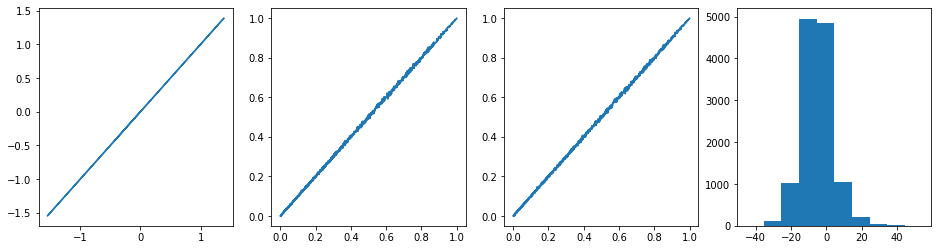

In [195]:
full_psilo_set = de_overlaps_significant_IT_lump['Psilo', 1]
psilo = full_psilo_set.copy()
psilo['simulation_de_mean'] = psilo['de_coef'] #rng.normal(loc=psilo['de_coef'], scale=psilo['de_se'])
psilo['simulation_test_statistic'] = (psilo['simulation_de_mean'] - 0) / psilo['de_se']
psilo['simulation_pval'] = 2 * scipystats.norm.sf(np.abs((psilo['simulation_de_mean'] - 0) / psilo['de_se']))
_, psilo['simulation_padj'], _, _ = multipletests(
    psilo["simulation_pval"], alpha=0.05, method='fdr_bh'
)

fig,ax = plt.subplots(1,4, figsize=(16,4))
ax[0].plot('de_coef','simulation_de_mean', data=psilo)
ax[1].plot('de_pval','simulation_pval', data=psilo)
ax[2].plot('de_pval_adj','simulation_padj', data=psilo)
ax[3].hist('simulation_test_statistic', data=psilo)

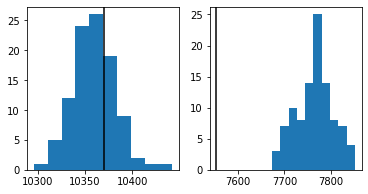

In [221]:
def number_of_simulated_DEGs(full_psilo_set, full_ket_set, num_bootstraps=10):
    num_des = np.zeros(shape=(num_bootstraps,2))
    rng = np.random.default_rng(2024)
    for i in range(num_bootstraps):
        psilo = full_psilo_set.copy()
        psilo['simulation_de_mean'] = rng.normal(loc=psilo['de_coef'], scale=psilo['de_se'])
        psilo['simulation_pval'] = 2 * scipystats.norm.sf(np.abs((psilo['simulation_de_mean'] - 0) / psilo['de_se']))
        _, psilo['simulation_padj'], _, _ = multipletests(
            psilo["simulation_pval"], alpha=0.05, method='fdr_bh'
        )
        
        ket = full_ket_set.copy()
        ket['simulation_de_mean'] = rng.normal(loc=ket['de_coef'], scale=ket['de_se'])
        ket['simulation_pval'] = 2 * scipystats.norm.sf(np.abs((ket['simulation_de_mean'] - 0) / ket['de_se']))
        _, ket['simulation_padj'], _, _ = multipletests(
            ket["simulation_pval"], alpha=0.05, method='fdr_bh'
        )
        
        num_des[i] = np.array([
            significant_entries(psilo, significance_column='simulation_padj').shape[0],
            significant_entries(ket, significance_column='simulation_padj').shape[0]
        ])
    
    return num_des

full_psilo_set = de_overlaps_significant_IT_lump['Psilo', 1]
full_ket_set = de_overlaps_significant_IT_lump['Ket', 1]
num_des = number_of_simulated_DEGs(full_psilo_set, full_ket_set, num_bootstraps=100)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].hist(num_des[:,0])
ax[0].axvline(significant_entries(full_psilo_set).shape[0], color='black')
ax[1].hist(num_des[:,1])
ax[1].axvline(significant_entries(full_ket_set).shape[0], color='black')

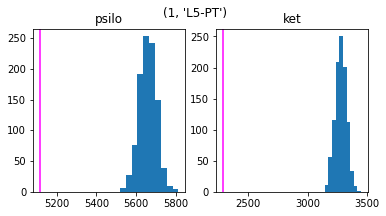

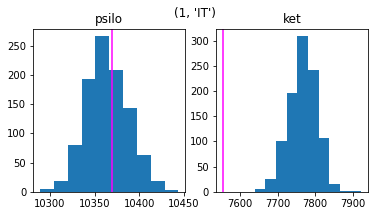

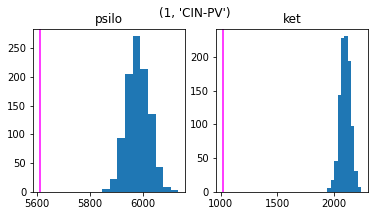

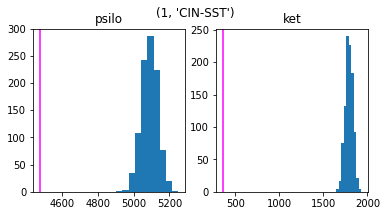

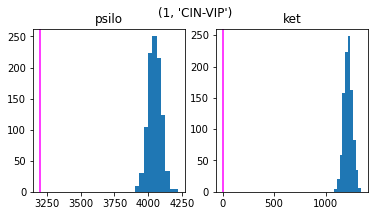

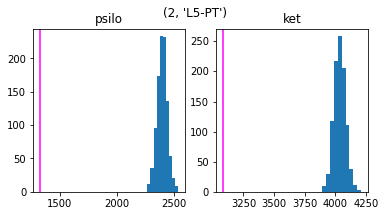

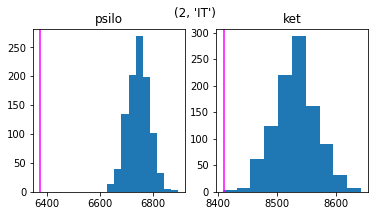

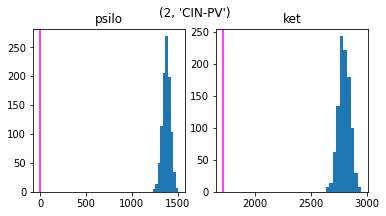

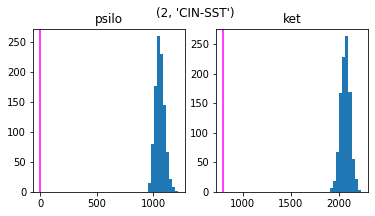

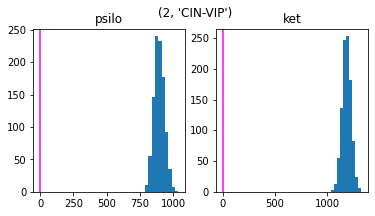

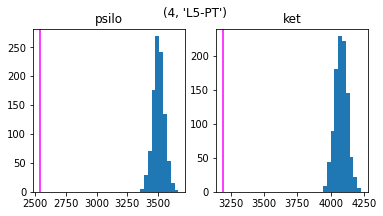

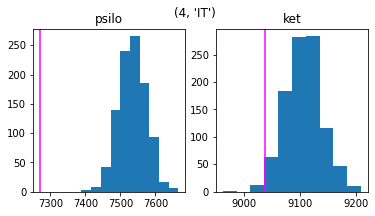

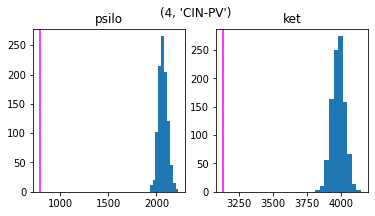

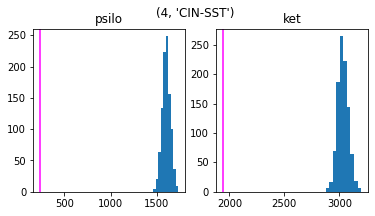

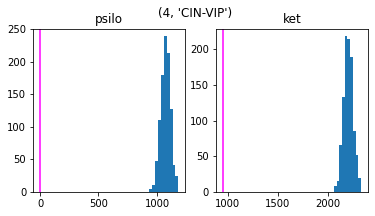

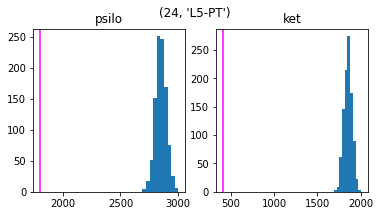

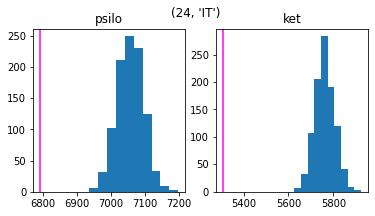

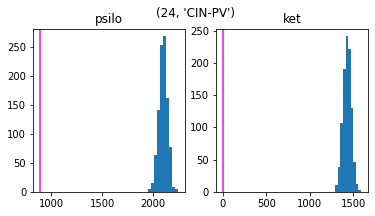

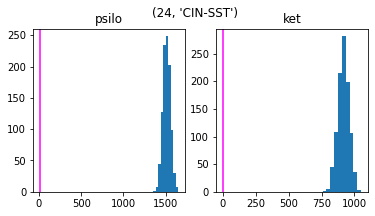

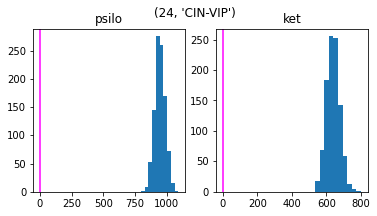

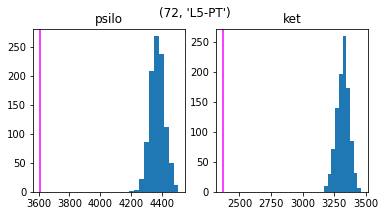

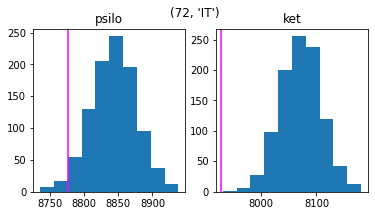

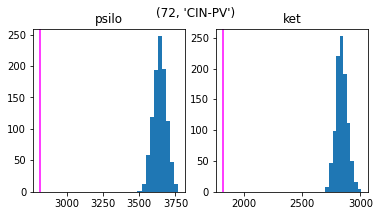

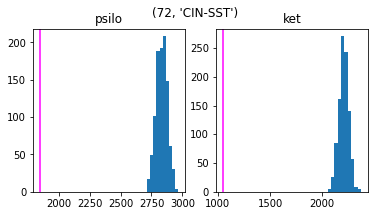

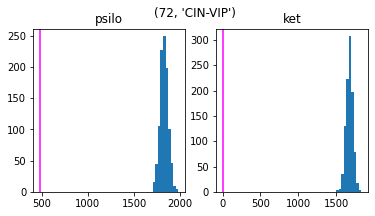

In [217]:
# %%time
for key in itertools.product(trt_times, ['L5-PT','IT','CIN-PV','CIN-SST','CIN-VIP']):
    if 'IT' not in key:
        full_psilo_set = de_overlaps_significant['Psilo', key[1], key[0]]
        full_ket_set = de_overlaps_significant['Ket', key[1], key[0]]
    else:
        full_psilo_set = de_overlaps_significant_IT_lump['Psilo', key[0]]
        full_ket_set = de_overlaps_significant_IT_lump['Ket', key[0]]
    
    num_des = number_of_simulated_DEGs(full_psilo_set, full_ket_set, num_bootstraps=1000)
    
    fig, ax = plt.subplots(1,2, figsize=(6,3))
    fig.suptitle(key)
    ax[0].hist(num_des[:,0])
    ax[0].axvline(significant_entries(full_psilo_set).shape[0], color='magenta')
    ax[0].set(title='psilo')
    ax[1].hist(num_des[:,1])
    ax[1].axvline(significant_entries(full_ket_set).shape[0], color='magenta')
    ax[1].set(title='ket')
    plt.show()
    plt.close()

False
0.27174764090717096 0.2756504190070706 0.29612389385819393


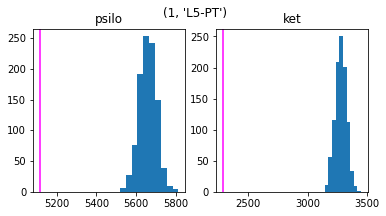

True
0.4802037682923829 0.48790640263015117 0.48716524400931155


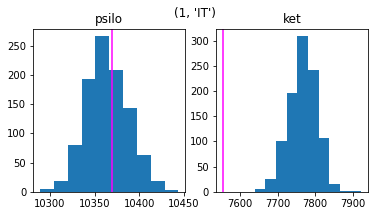

True
0.18586689540078363 0.1772363655018745 0.21426642394141743


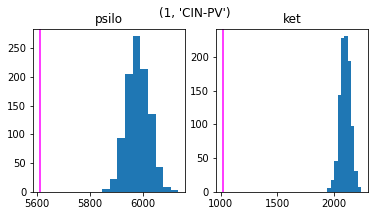

True
0.19742657478229458 0.14126715542648902 0.22801354389326967


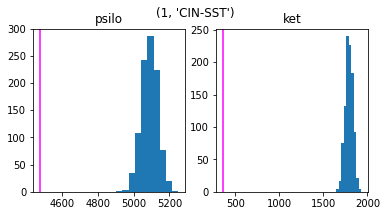

True
0.14274016016113655 0.0 0.17661025674064504


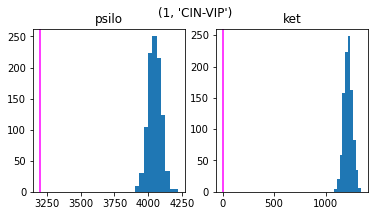

True
0.4078416256897984 0.4527270782663662 0.44145248493594347


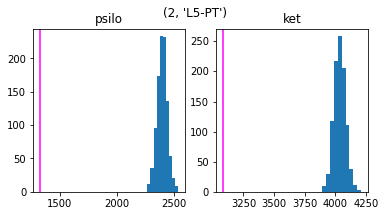

True
0.5867050655112175 0.5968437200966037 0.5959727304163501


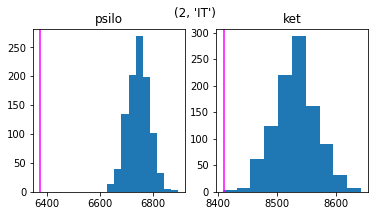

False
0.21841399907068823 nan 0.2547321064340224


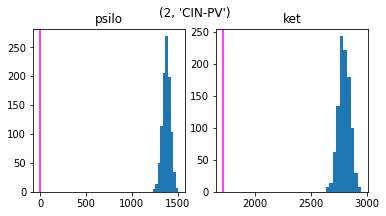

False
0.20925947423967806 nan 0.25744665447622317


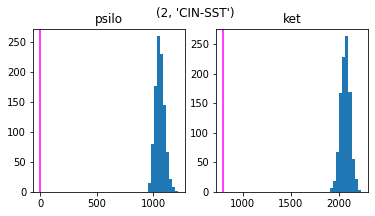

False
0.18156808782418818 nan 0.24531755949177905


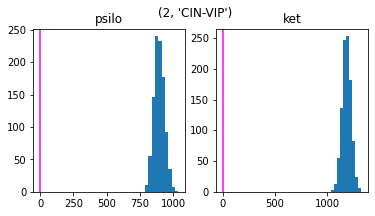

True
0.49803948556652045 0.5281473795452435 0.5219646060305267


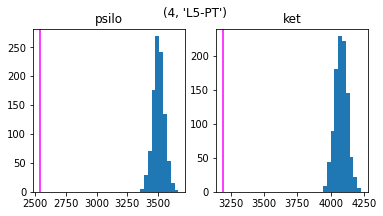

False
0.641146046842763 0.6468858170235976 0.646886828007224


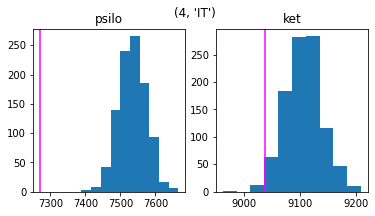

False
0.3644712052350687 0.38940992284314035 0.39505646087137863


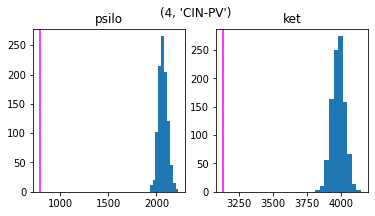

True
0.32984105789680207 0.31891390887761145 0.37160185827121717


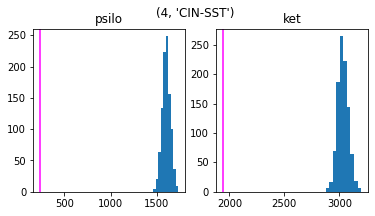

True
0.2952785179447924 0.08625317067892944 0.3415618302502997


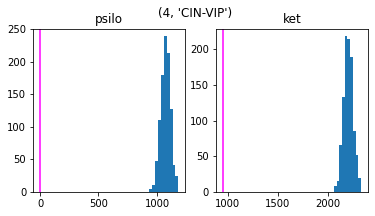

False
0.22150986676204398 0.23832012578016384 0.261855244441539


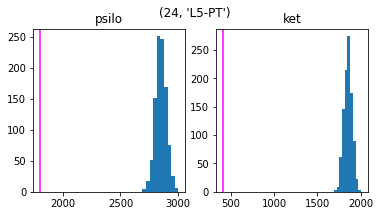

True
0.5671796221911777 0.5864556411820347 0.5790876461756694


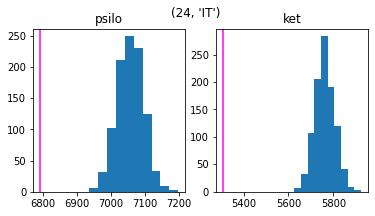

True
0.11995336145833156 0.0 0.16069169388216387


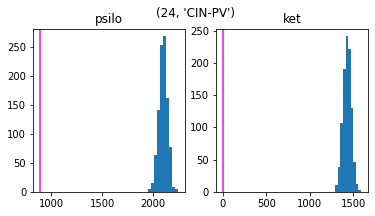

False
0.11096233684528133 nan 0.1669447119108595


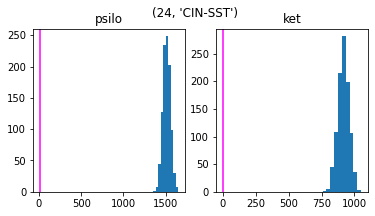

False
0.12085510753043613 nan 0.17848787534901533


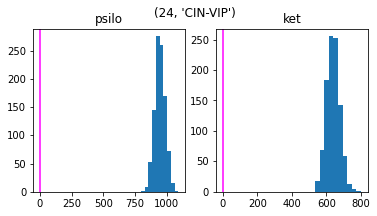

False
0.3388177219479273 0.35672370691213495 0.36744421177182496


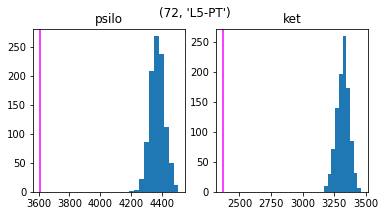

True
0.5205777641404483 0.5321634683802475 0.5294120731587327


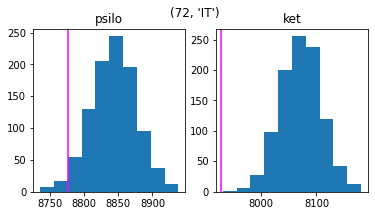

False
0.31311957617554637 0.3294286752853993 0.35148803104793275


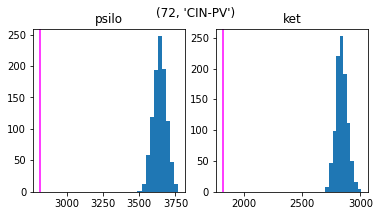

True
0.28587536393725127 0.33455755054911024 0.324781847930836


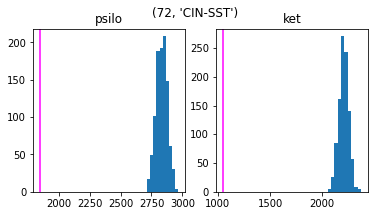

False
0.1882325693423658 nan 0.23101207722706213


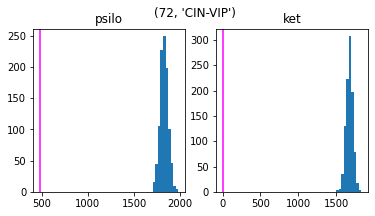

In [223]:
# %%time

interdrug_dict = {tup:{} for tup in list(itertools.product(trt_times, ['L5-PT','IT','CIN-PV','CIN-SST','CIN-VIP']))}

# for key, data in itertools.islice(interdrug_dict.items(), 3):
for key, data in interdrug_dict.items():
    if 'IT' not in key:
        full_psilo_set = de_overlaps_significant['Psilo', key[1], key[0]]
        full_ket_set = de_overlaps_significant['Ket', key[1], key[0]]
    else:
        full_psilo_set = de_overlaps_significant_IT_lump['Psilo', key[0]]
        full_ket_set = de_overlaps_significant_IT_lump['Ket', key[0]]
    
    sig_psilo_set = significant_entries(full_psilo_set)
    sig_ket_set = significant_entries(full_ket_set)
        
    data['num_psilo_DE'] = sig_psilo_set.shape[0]
    data['num_ket_DE'] = sig_ket_set.shape[0]
    data['num_shared_DE'] = sig_psilo_set.merge(sig_ket_set, how='inner', on='gene').shape[0]
    data['similarity'] = cosine_similarity(sig_psilo_set, sig_ket_set)
    data['similarity_sd'], data['similarity_ci_lb'], data['similarity_ci_ub'] = similarity_error(full_psilo_set, full_ket_set, num_bootstraps=100)
    data['similarity_error_down'] = np.abs(data['similarity_ci_lb'] - data['similarity'])
    data['similarity_error_up'] = np.abs(data['similarity_ci_ub'] - data['similarity'])
    
    print(data['similarity_ci_lb'] > data['similarity'] or data['similarity'] > data['similarity_ci_ub'])
    print(data['similarity_ci_lb'], data['similarity'], data['similarity_ci_ub'])
    num_des = number_of_simulated_DEGs(full_psilo_set, full_ket_set, num_bootstraps=1000)
    
    fig, ax = plt.subplots(1,2, figsize=(6,3))
    fig.suptitle(key)
    ax[0].hist(num_des[:,0])
    ax[0].axvline(significant_entries(full_psilo_set).shape[0], color='magenta')
    ax[0].set(title='psilo')
    ax[1].hist(num_des[:,1])
    ax[1].axvline(significant_entries(full_ket_set).shape[0], color='magenta')
    ax[1].set(title='ket')
    plt.show()
    plt.close()
#     break

In [154]:
interdrug_list = [
    {'time':key[0], 'cluster':key[1], 
     'num_psilo_DE':data['num_psilo_DE'], 'num_ket_DE':data['num_ket_DE'], 
     'num_shared_DE':data['num_shared_DE'], 
     'similarity':data['similarity'], 'similarity_sd':data['similarity_sd'],
     'similarity_ci_lb':data['similarity_ci_lb'], 'similarity_ci_ub':data['similarity_ci_ub'],
     'similarity_error_down':data['similarity_error_down'], 'similarity_error_up':data['similarity_error_up']}
    for key,data in interdrug_dict.items()
]
interdrug_df = pd.DataFrame(interdrug_list)
interdrug_df.to_csv(os.path.join(this_figure_dir, 'interdrug_similarity_comprehensive_data.csv'))
interdrug_df.head()

,time,cluster,num_psilo_DE,num_ket_DE,num_shared_DE,similarity,similarity_sd,similarity_ci_lb,similarity_ci_ub,similarity_error_down,similarity_error_up
0,1,L5-PT,5117,2284,1155,0.275650,0.006986,0.271748,0.296124,0.003903,0.020473
1,1,IT,10370,7554,6291,0.487906,0.001805,0.480204,0.487165,0.007703,0.000741
2,1,CIN-PV,5611,1018,575,0.177236,0.007633,0.185867,0.214266,0.008631,0.037030
3,1,CIN-SST,4475,359,180,0.141267,0.007912,0.197427,0.228014,0.056159,0.086746
4,1,CIN-VIP,3199,2,0,0.000000,0.008931,0.142740,0.176610,0.142740,0.176610


<AxesSubplot: >

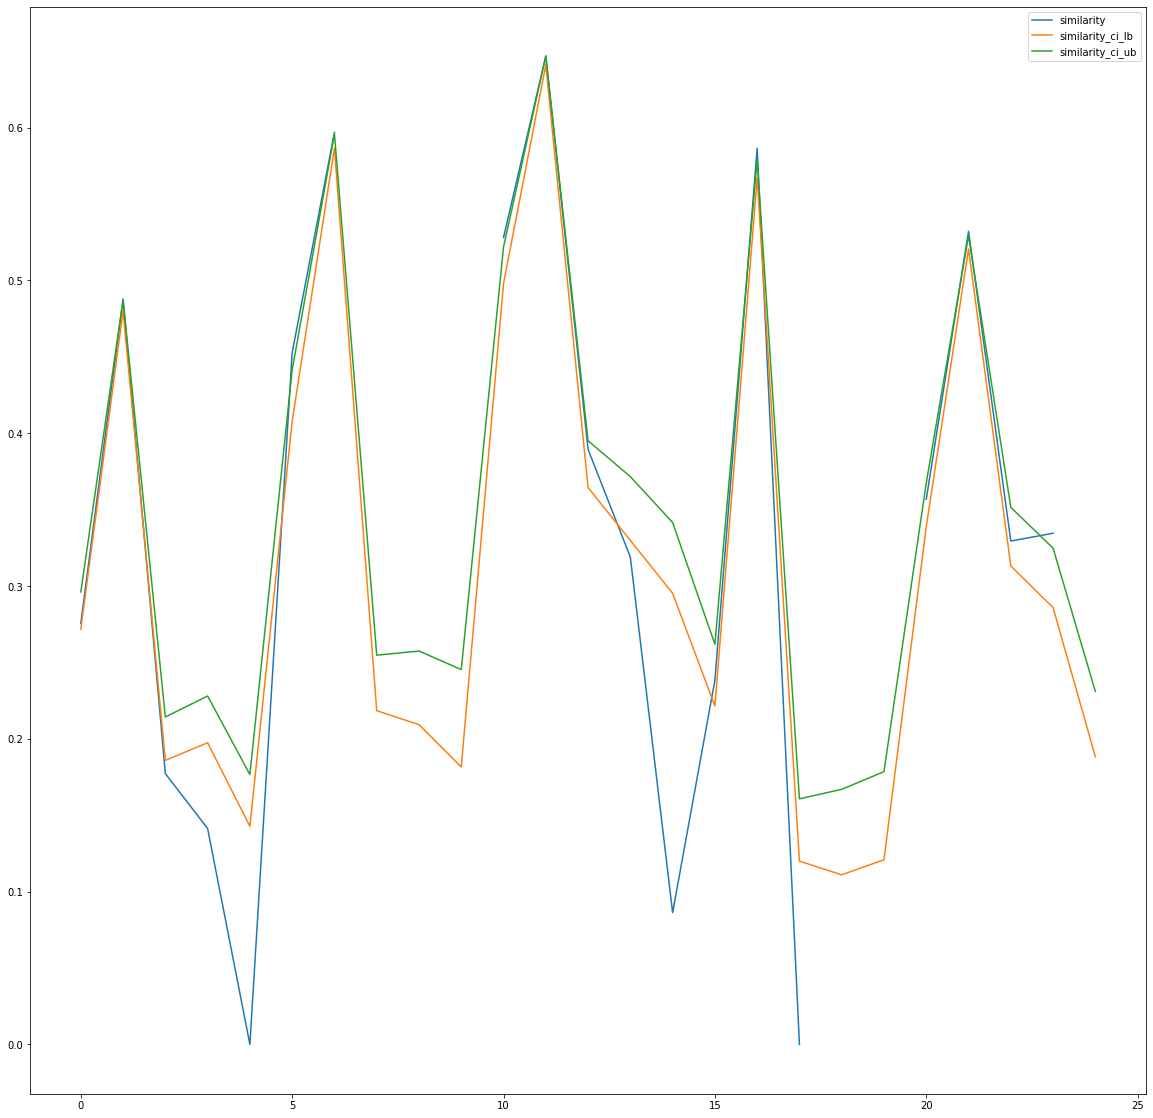

In [155]:
interdrug_df.plot.line(y=['similarity', 'similarity_ci_lb', 'similarity_ci_ub'], figsize=(20,20))

In [141]:
interdrug_df['psilo_fraction'] = interdrug_df['num_shared_DE'] / interdrug_df['num_psilo_DE']
interdrug_df['ket_fraction'] = interdrug_df['num_shared_DE'] / interdrug_df['num_ket_DE']
interdrug_df['one'] = 1.0
interdrug_df.isna().sum()

time                     0
cluster                  0
num_psilo_DE             0
num_ket_DE               0
num_shared_DE            0
similarity               6
similarity_sd            0
similarity_ci_lb         0
similarity_ci_ub         0
similarity_error_down    6
similarity_error_up      6
psilo_fraction           3
ket_fraction             4
one                      0
dtype: int64

In [142]:
def myround(x, base=5):
    return base * round(x/base)

## Plot original concept

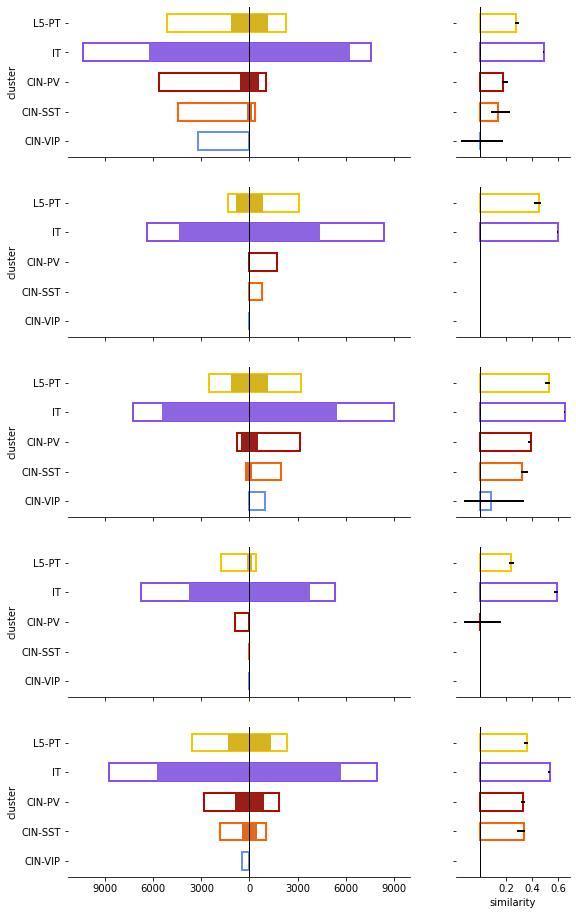

In [138]:
def plot_axis(data, axes_row):
    BAR_WIDTH = 0.6
    LINE_WIDTH = 2.0
    sns.barplot(
        data=data,
        x='num_ket_DE', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x = -data['num_psilo_DE'], y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )

    sns.barplot(
        data=data,
        x='num_shared_DE', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x= -data['num_shared_DE'], y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    
    sns.barplot(
        data=data,
        x='similarity', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[1],
    )
    axes_row[1].errorbar(
        x='similarity', y='cluster', 
        xerr=data[['similarity_error_down', 'similarity_error_up']].to_numpy().T, 
        data=data, ecolor='black', barsabove=True, linestyle='none'
    )
    
gs_kw = dict(width_ratios=[3,1],)    
fig, axes = plt.subplots(5, 2, figsize=(9,16), gridspec_kw=gs_kw,
                        sharey='row', sharex='col')
fig.set_facecolor('white')

sns.despine(fig=fig, top=True, right=True, left=True, bottom=False)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.axvline(0, linestyle='-', color='black', linewidth=1)

    for ax_index, time in enumerate(trt_times):
        plot_axis(interdrug_df.query(f'time == {time}'), axes[ax_index])

max_de_size = interdrug_df[['num_psilo_DE','num_ket_DE']].max().max()
de_size_ticks = np.arange(myround(-max_de_size, base=3000), myround(max_de_size, base=3000)+1, 3000)
axes[-1][0].set_xticks(de_size_ticks, labels=np.abs(de_size_ticks))
axes[-1][-1].set_xticks(np.arange(0.2, interdrug_df['similarity'].max(), 0.2))

fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive_errorbar.png")
fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive_errorbar.pdf")

## Plot only fractions of cells, not counts

The original concept was a bit confusing because this uses memento DE data, even though it directly proceeds figures 3-6 which are all pseudobulked.

We will still use memento data, but plotting fractions hides the count axis. Kinda deceiving but less likely to immediately throw off the reader (is alex's POV)

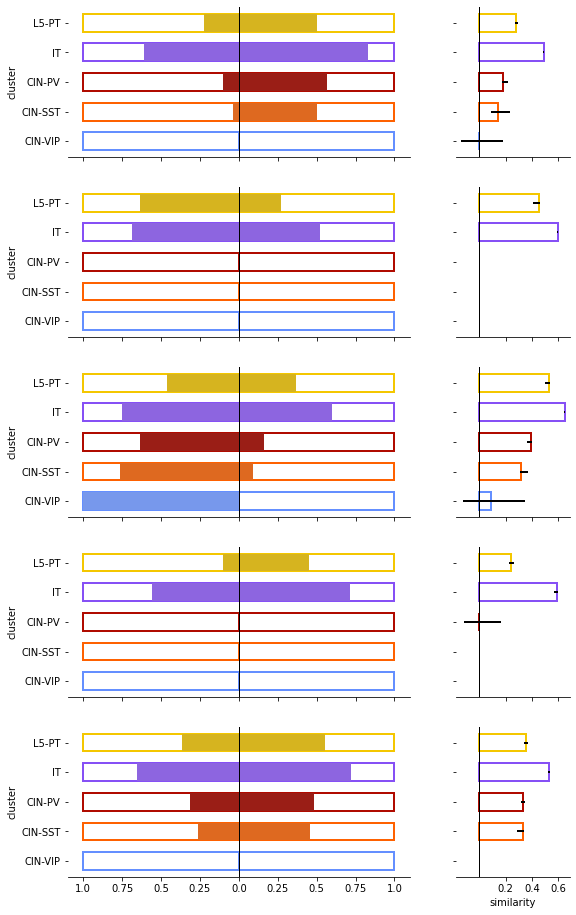

In [73]:
def plot_axis(data, axes_row):
    BAR_WIDTH = 0.6
    LINE_WIDTH = 2.0

    sns.barplot(
        data=data,
        x='one', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x = -data['one'], y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    
    sns.barplot(
        data=data,
        x='ket_fraction', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x= -data['psilo_fraction'], y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    
    sns.barplot(
        data=data,
        x='similarity', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[1],
    )
    axes_row[1].errorbar(
        x='similarity', y='cluster', 
        xerr=data[['similarity_error_down', 'similarity_error_up']].to_numpy().T, 
        data=data, ecolor='black', barsabove=True, linestyle='none'
    )
    
gs_kw = dict(width_ratios=[3,1],)    
fig, axes = plt.subplots(5, 2, figsize=(9,16), gridspec_kw=gs_kw,
                        sharey='row', sharex='col')
fig.set_facecolor('white')

sns.despine(fig=fig, top=True, right=True, left=True, bottom=False)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.axvline(0, linestyle='-', color='black', linewidth=1)

    for ax_index, time in enumerate(trt_times):
        plot_axis(interdrug_df.query(f'time == {time}'), axes[ax_index])

frac_max = 1.0
de_frac_ticks = np.linspace(-frac_max, frac_max, 9)
axes[-1][0].set_xticks(de_frac_ticks, labels=np.abs(de_frac_ticks))
axes[-1][-1].set_xticks(np.arange(0.2, interdrug_df['similarity'].max(), 0.2))

fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive_fractions.png")
fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive_fractions.pdf")

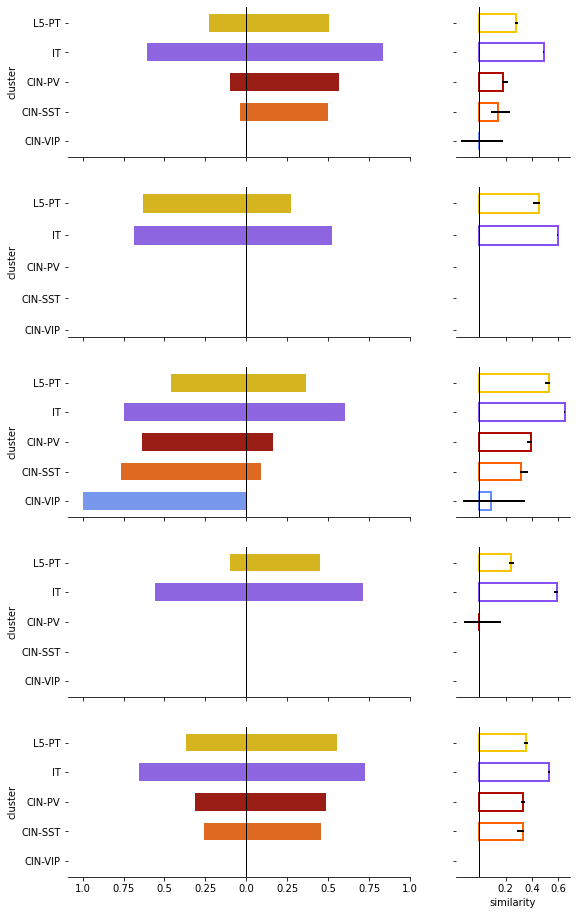

In [74]:
def plot_axis(data, axes_row):
    BAR_WIDTH = 0.6
    LINE_WIDTH = 2.0

    sns.barplot(
        data=data,
        x='ket_fraction', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x= -data['psilo_fraction'], y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    
    sns.barplot(
        data=data,
        x='similarity', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[1],
    )
    axes_row[1].errorbar(
        x='similarity', y='cluster', 
        xerr=data[['similarity_error_down', 'similarity_error_up']].to_numpy().T, 
        data=data, ecolor='black', barsabove=True, linestyle='none'
    )
    
gs_kw = dict(width_ratios=[3,1],)    
fig, axes = plt.subplots(5, 2, figsize=(9,16), gridspec_kw=gs_kw,
                        sharey='row', sharex='col')
fig.set_facecolor('white')

sns.despine(fig=fig, top=True, right=True, left=True, bottom=False)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.axvline(0, linestyle='-', color='black', linewidth=1)

    for ax_index, time in enumerate(trt_times):
        plot_axis(interdrug_df.query(f'time == {time}'), axes[ax_index])

frac_max = 1.0
de_frac_ticks = np.linspace(-frac_max, frac_max, 9)
axes[-1][0].set_xticks(de_frac_ticks, labels=np.abs(de_frac_ticks))
axes[-1][-1].set_xticks(np.arange(0.2, interdrug_df['similarity'].max(), 0.2))

fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive_fractions_no_container.png")
fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive_fractions_no_container.pdf")

[[0.03396146 0.00665817]
 [0.00583765 0.00032743]
 [0.02904385 0.00968779]
 [0.0156205  0.04725132]
 [0.21157394 0.25301582]]


<ErrorbarContainer object of 3 artists>

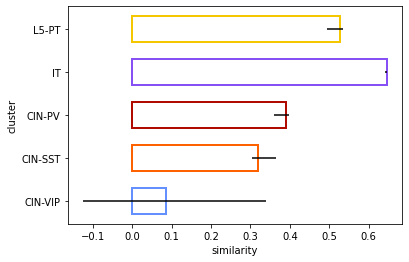

In [150]:
data = interdrug_df.query(f'time == 4')
print(data[['similarity_error_down', 'similarity_error_up']].to_numpy())
BAR_WIDTH = 0.6
LINE_WIDTH = 2.0

sns.barplot(
    data=data,
    x='similarity', y='cluster', hue='cluster',
    palette=cluster_colors, hue_order=color_order,
    fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
)

plt.errorbar('similarity', 'cluster', xerr=data[['similarity_error_down', 'similarity_error_up']].to_numpy().T, 
             data=data, ecolor='black', barsabove=True, linestyle='none')

In [123]:
tuple(np.quantile(np.random.normal(size=100), [0.025, .975]))

(-1.8876994067973911, 2.23248878360101)

# Fig 7 Scatterplot

1hr, 72hr and PT, IT, CIN (6 total plots)

In [14]:
this_figure_dir = f'{settings.fig_path}/figure_7'
os.makedirs(this_figure_dir, exist_ok=True)

In [15]:
celltype_paths = {
    'PT': 'figure_3/pseudobulk_clusters_counts/',
    'IT': 'figure_4/pseudobulk_clusters_counts/',
    'CIN': 'figure_5/pseudobulk_clusters_counts/'
}
scatter_times = [1,2,4,24,72]
# [ os.path.join(settings.fig_path, path, f'DEGs_{time}h_{drug}.csv') 
#  for (name,path), time, drug in itertools.product(celltype_paths.items(), scatter_times, trt_drugs)]

In [16]:
pseudobulk_de_dataframes = []
for name, path in celltype_paths.items():
    for time in scatter_times:
        for drug in trt_drugs:
            df = pd.read_csv(os.path.join(settings.fig_path, 
                                          path, 
                                          f'DEGs_{"CIN_" if name=="CIN" else ""}{time}h_{drug}.csv'),
                            index_col=0)
            df = df.reset_index(drop=True)
            df['celltype'] = name
            df['time'] = time
            df['drug'] = drug
            pseudobulk_de_dataframes.append(df)

print(len(pseudobulk_de_dataframes))
pseudobulk_de_dataframes = pd.concat(pseudobulk_de_dataframes)
pseudobulk_de_dataframes

30


,logFC,logCPM,LR,PValue,ctrl.logCPM,cKO.logCPM,gene_name,FDR,celltype,time,drug
0,1.103766,3.784495,2.541513e+01,4.622789e-07,3.367438,4.394425,Pkp2,0.006298,PT,1,Ket
1,0.689292,5.070024,2.286322e+01,1.739490e-06,4.843728,5.499549,Zmiz1,0.011849,PT,1,Ket
2,0.433548,10.681409,2.152493e+01,3.492581e-06,10.547065,10.979453,Grin2b,0.015861,PT,1,Ket
3,-1.155972,4.206206,2.053693e+01,5.849194e-06,4.396641,3.282048,Krt12,0.019922,PT,1,Ket
4,-0.964208,5.469309,2.004331e+01,7.570786e-06,5.644451,4.707964,Rad51ap2,0.020629,PT,1,Ket
...,...,...,...,...,...,...,...,...,...,...,...
13652,-0.000065,6.421808,5.197642e-07,9.994248e-01,6.418171,6.420247,Tent4b,0.999634,CIN,72,Psilo
13653,-0.000060,7.472937,4.318164e-07,9.994757e-01,7.466105,7.472916,Ccny,0.999634,CIN,72,Psilo
13654,-0.000057,7.700227,4.116126e-07,9.994881e-01,7.695341,7.699218,Shtn1,0.999634,CIN,72,Psilo
13655,-0.000063,2.601015,2.355092e-08,9.998776e-01,2.578488,2.577135,Pcsk6,0.999933,CIN,72,Psilo


In [17]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    # Raw data
    dct = {
        'y_true': y_true,
        'y_pred': y_pred
    }
    df = pd.DataFrame(dct)
    # Remove NaNs
    df = df.dropna()
    # Pearson product-moment correlation coefficients
    y_true = df['y_true']
    y_pred = df['y_pred']
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Means
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Population variances
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Population standard deviations
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2

    return numerator / denominator

### regression on sig genes

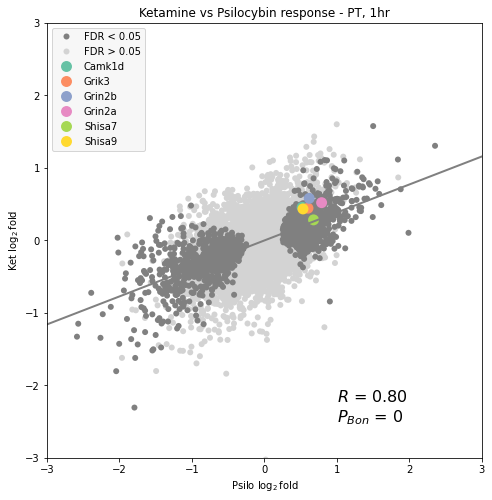

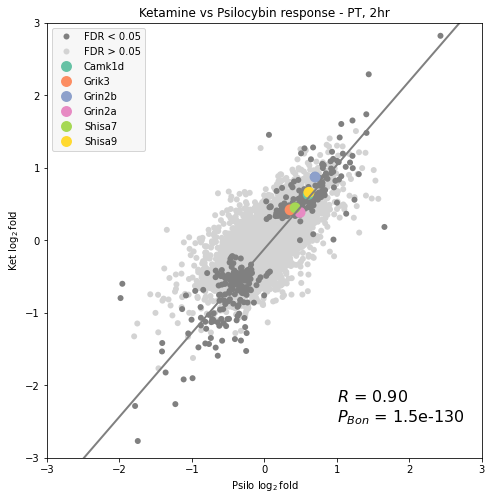

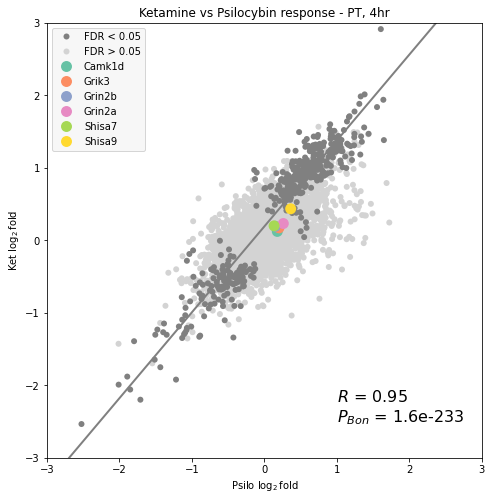

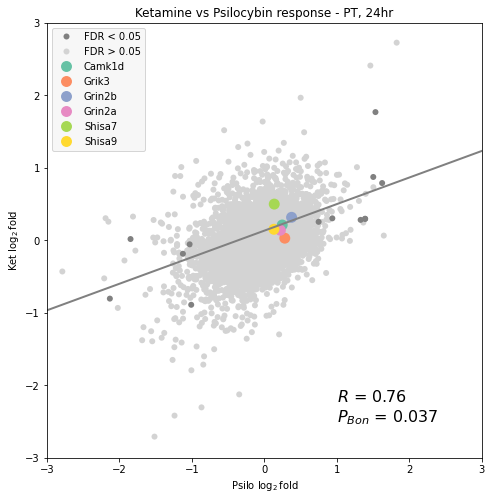

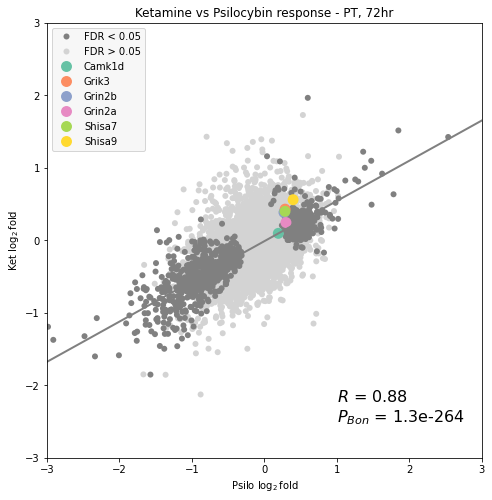

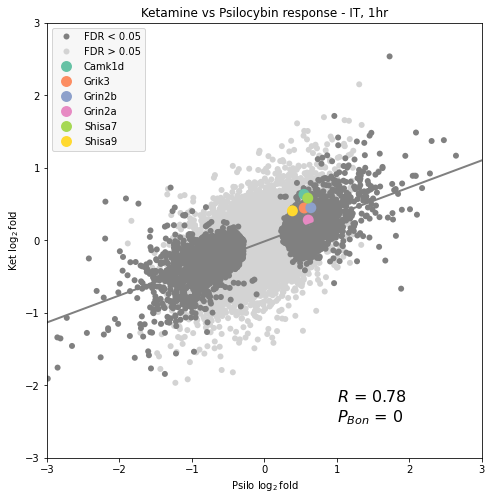

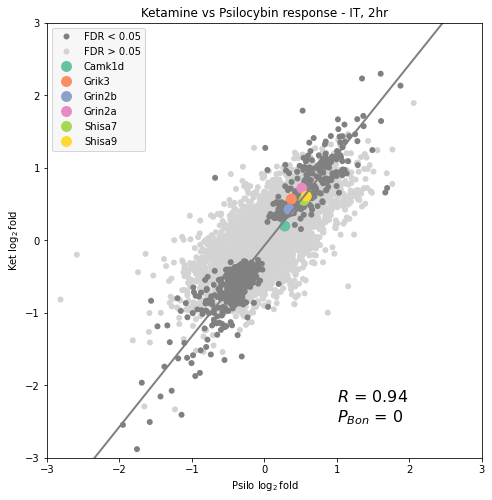

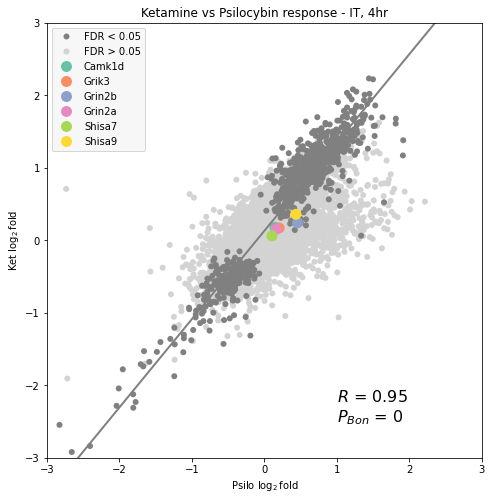

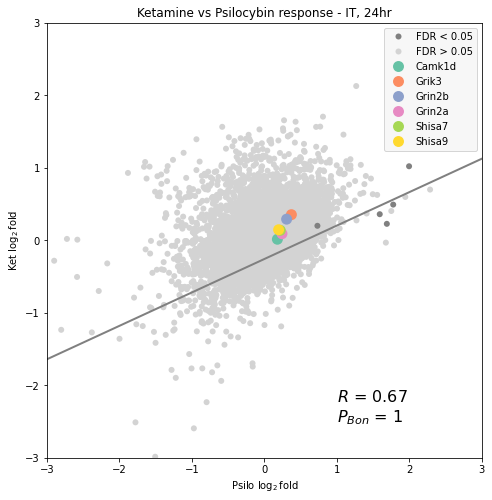

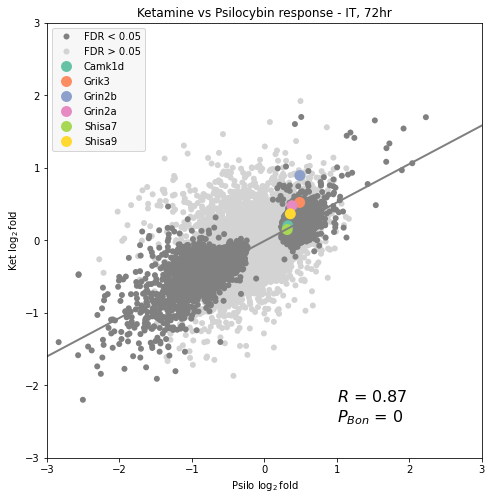

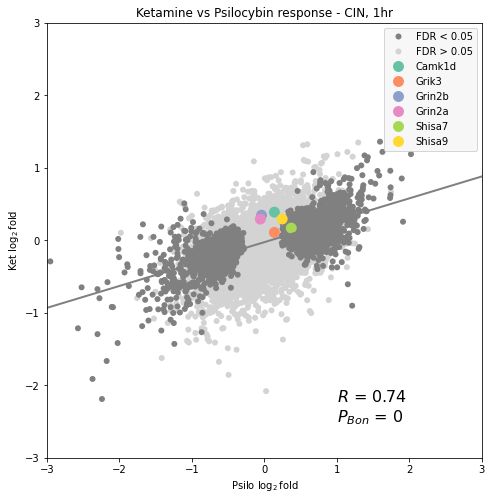

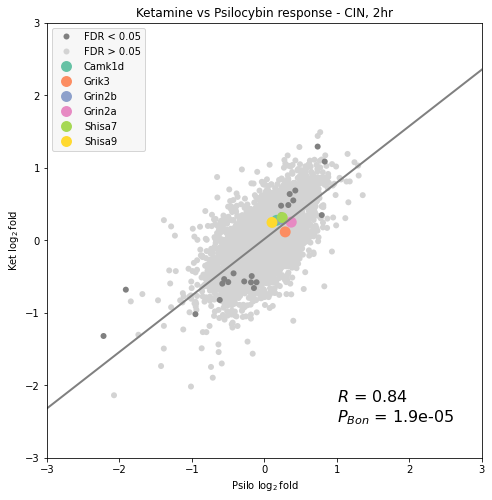

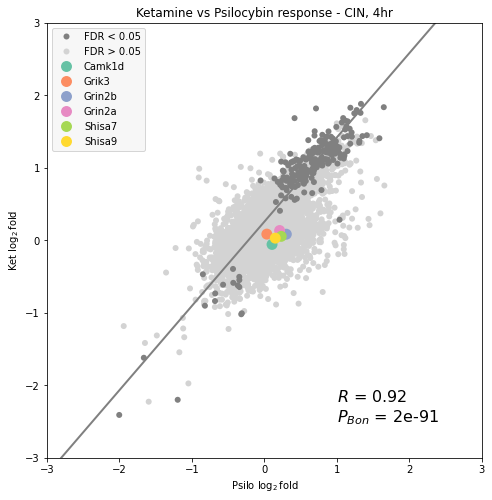

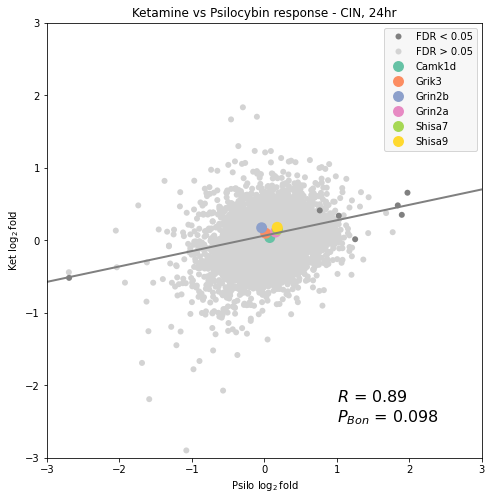

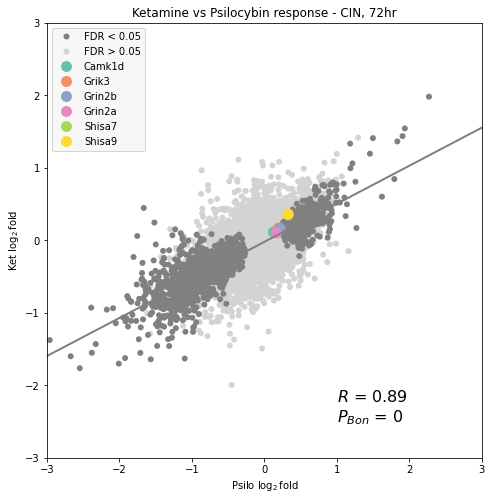

In [19]:
def plot_interdrug_scatter(data, celltype, time, important_genes=[]):
    data['is_significant'] = (data['FDR_psilo'] < 0.05) | (data['FDR_ket'] < 0.05)
    data = data.sort_values('is_significant')
    fig, ax = plt.subplots(figsize=(8,8))
    
    sns.scatterplot(
        data=data, x='logFC_psilo', y='logFC_ket',
        hue='is_significant', palette=['grey','lightgrey'], hue_order=[True,False],
        linewidth=0,
        ax = ax
    )
    
    regression_x = data[data['is_significant']]['logFC_psilo']
    regression_y = data[data['is_significant']]['logFC_ket']
    
    regression_res = scipystats.linregress(regression_x, regression_y)
    correlation, p_value = scipystats.pearsonr(regression_x, regression_y)
    
    # pre-hoc bonferroni correction
    p_value = min(1.0, p_value*15)
    ax.text(1,-2.5, f'$R$ = {correlation:.2f}\n$P_{{Bon}}$ = {p_value:.2g}', fontsize=16)
    ax.axline((0,regression_res.intercept), slope=regression_res.slope, c='grey', linewidth=2)
    
    label_data = data[data['gene_name'].isin(important_genes)]
    sns.scatterplot(
        data=label_data,
        x='logFC_psilo', y='logFC_ket',
        hue='gene_name', palette='Set2', linewidth=0, s=120,
        ax=ax
    )
    
    ax.set_title(f'Ketamine vs Psilocybin response - {celltype}, {time}hr')
    ax.set(xlabel='Psilo $\log_2$fold', ylabel='Ket $\log_2$fold',
          xlim=(-3,3), ylim=(-3,3))
    ax.set_box_aspect(1.0)
    ax.legend(handles=ax.legend().legendHandles, 
              labels=['FDR < 0.05', 'FDR > 0.05']+important_genes, 
              title=None, 
              facecolor='whitesmoke')
    return fig
    
    
for name, time in itertools.product(celltype_paths.keys(), scatter_times):
    df = pseudobulk_de_dataframes[(pseudobulk_de_dataframes['celltype'] == name) &
                                  (pseudobulk_de_dataframes['time'] == time)]
    psilo_degs = df[df['drug'] == 'Psilo']
    ket_degs = df[df['drug'] == 'Ket']
    df = psilo_degs.merge(ket_degs, on=['gene_name','celltype','time'], how='inner', suffixes=('_psilo','_ket'))
    # df = df[(df['FDR_psilo'] < 0.05) | (df['FDR_ket'] < 0.05)]
    
    genes_to_label = ['Camk1d','Grik3','Grin2b','Grin2a','Shisa7','Shisa9']
    fig = plot_interdrug_scatter(df, name, time, important_genes=genes_to_label)
    plt.show(fig)
    fig.savefig(f"{this_figure_dir}/scatter_{name}_{time}h.png", dpi=600)
    fig.savefig(f"{this_figure_dir}/scatter_{name}_{time}h.pdf", dpi=600)
#     break

### dont color GOI if insig

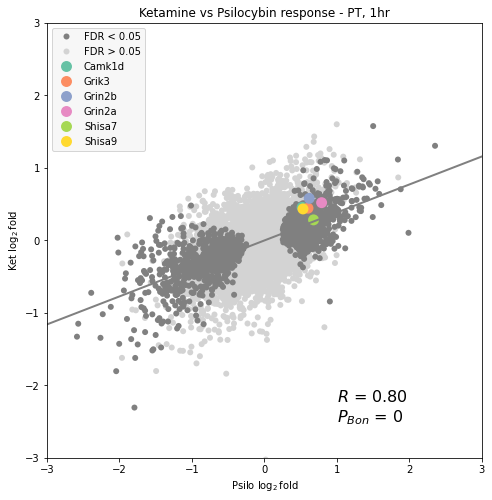

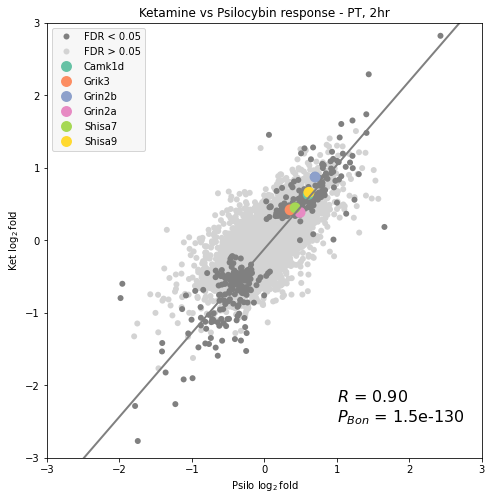

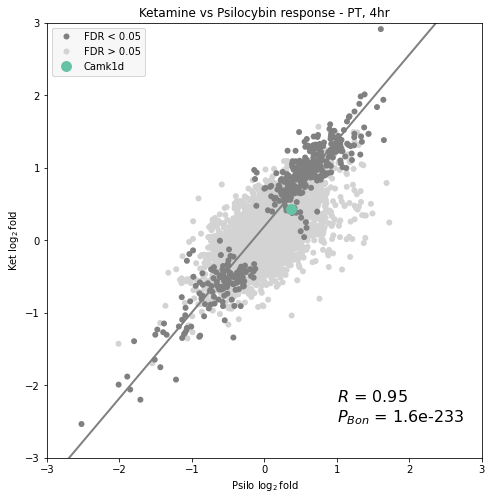

/tmp/ipykernel_698371/3922807127.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


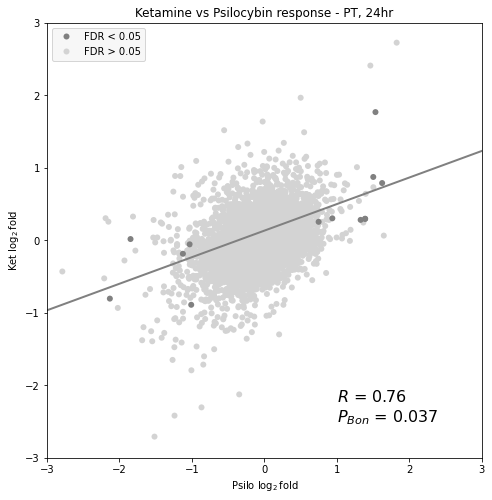

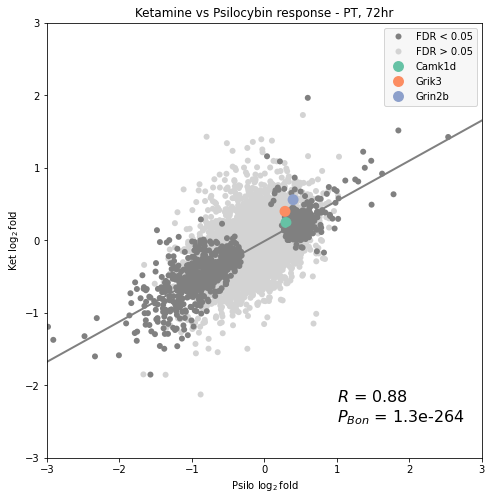

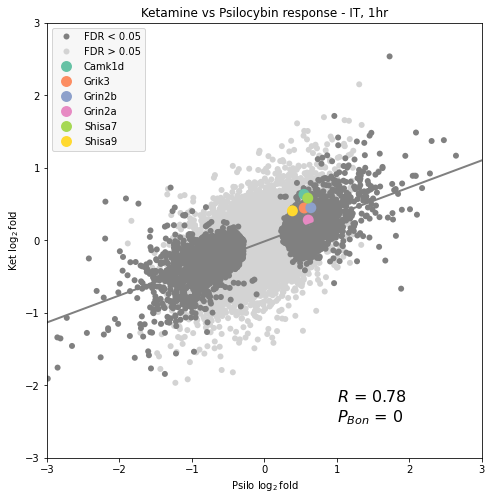

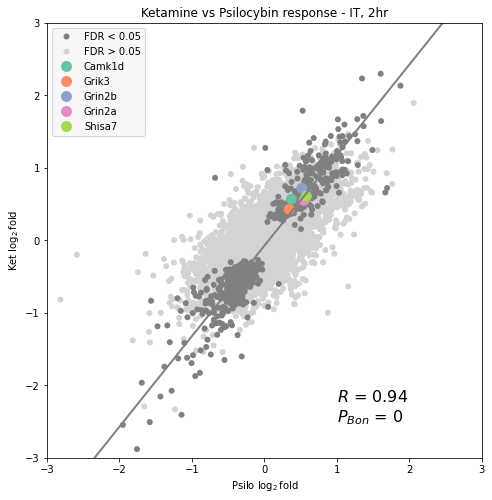

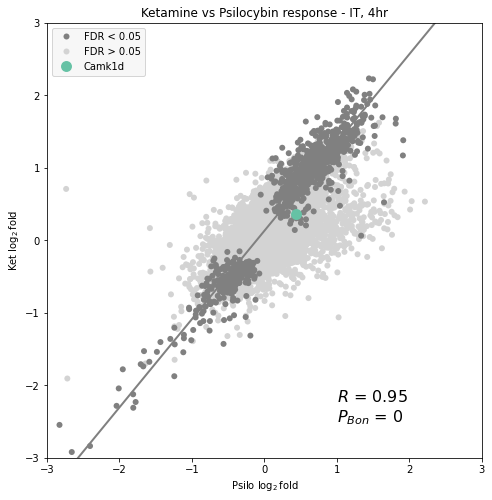

/tmp/ipykernel_698371/3922807127.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


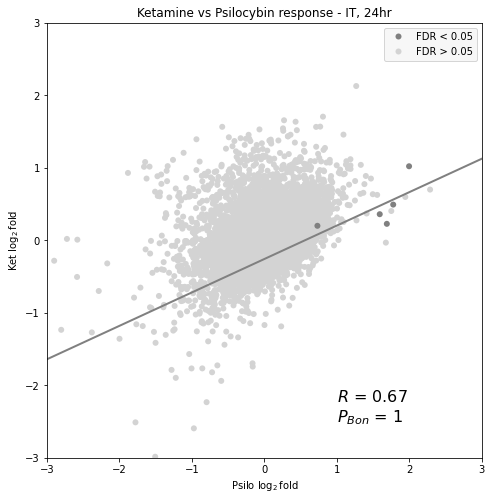

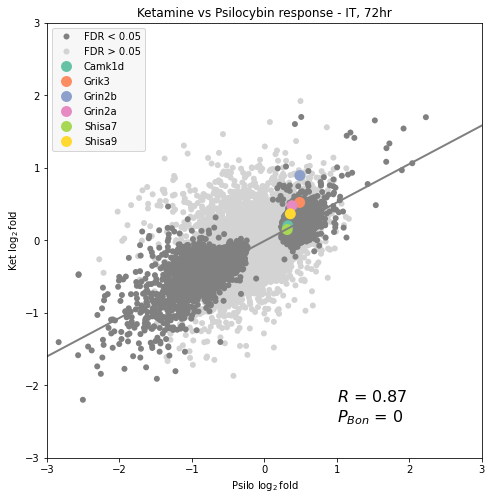

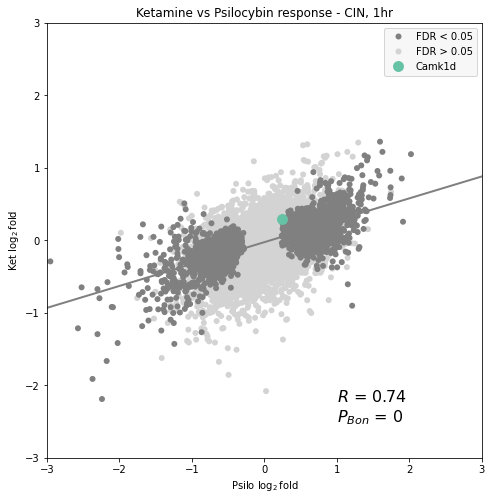

/tmp/ipykernel_698371/3922807127.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


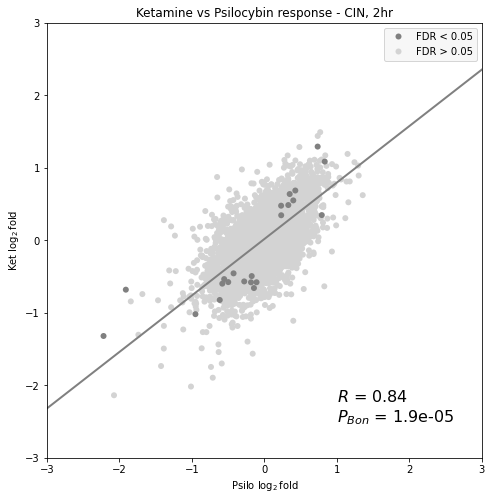

/tmp/ipykernel_698371/3922807127.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


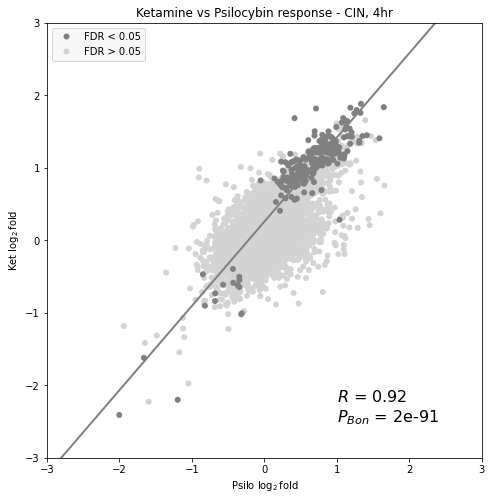

/tmp/ipykernel_698371/3922807127.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


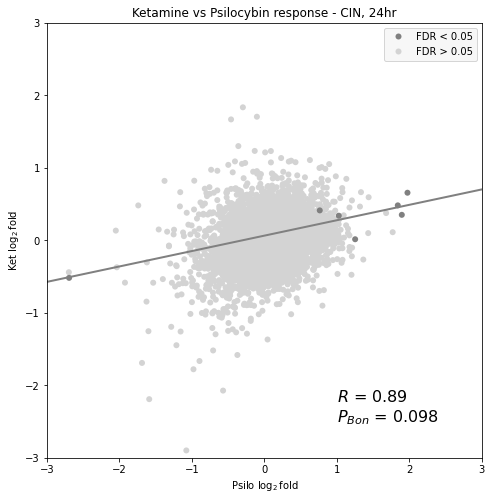

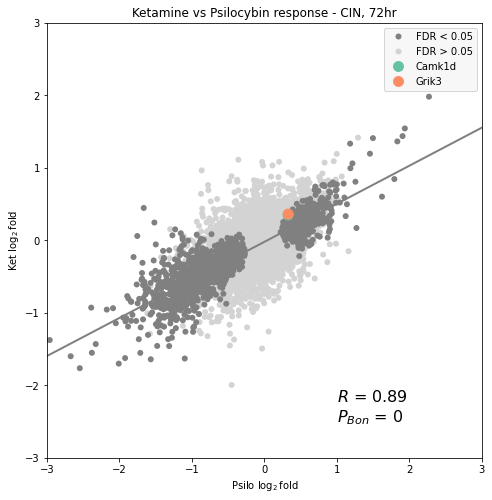

In [23]:
def plot_interdrug_scatter(data, celltype, time, important_genes=[]):
    data['is_significant'] = (data['FDR_psilo'] < 0.05) | (data['FDR_ket'] < 0.05)
    data = data.sort_values('is_significant')
    fig, ax = plt.subplots(figsize=(8,8))
    
    sns.scatterplot(
        data=data, x='logFC_psilo', y='logFC_ket',
        hue='is_significant', palette=['grey','lightgrey'], hue_order=[True,False],
        linewidth=0,
        ax = ax
    )
    
    regression_x = data[data['is_significant']]['logFC_psilo']
    regression_y = data[data['is_significant']]['logFC_ket']
    
    regression_res = scipystats.linregress(regression_x, regression_y)
    correlation, p_value = scipystats.pearsonr(regression_x, regression_y)
    
    # pre-hoc bonferroni correction
    p_value = min(1.0, p_value*15)
    ax.text(1,-2.5, f'$R$ = {correlation:.2f}\n$P_{{Bon}}$ = {p_value:.2g}', fontsize=16)
    ax.axline((0,regression_res.intercept), slope=regression_res.slope, c='grey', linewidth=2)
    
    label_data = data[(data['gene_name'].isin(important_genes)) &
                      (data['is_significant'] == True)]
    sns.scatterplot(
        data=label_data,
        x='logFC_psilo', y='logFC_ket',
        hue='gene_name', palette='Set2', linewidth=0, s=120,
        ax=ax
    )
    
    ax.set_title(f'Ketamine vs Psilocybin response - {celltype}, {time}hr')
    ax.set(xlabel='Psilo $\log_2$fold', ylabel='Ket $\log_2$fold',
          xlim=(-3,3), ylim=(-3,3))
    ax.set_box_aspect(1.0)
    ax.legend(handles=ax.legend().legendHandles, 
              labels=['FDR < 0.05', 'FDR > 0.05']+important_genes, 
              title=None, 
              facecolor='whitesmoke')
    return fig
    
    
for name, time in itertools.product(celltype_paths.keys(), scatter_times):
    df = pseudobulk_de_dataframes[(pseudobulk_de_dataframes['celltype'] == name) &
                                  (pseudobulk_de_dataframes['time'] == time)]
    psilo_degs = df[df['drug'] == 'Psilo']
    ket_degs = df[df['drug'] == 'Ket']
    df = psilo_degs.merge(ket_degs, on=['gene_name','celltype','time'], how='inner', suffixes=('_psilo','_ket'))
    # df = df[(df['FDR_psilo'] < 0.05) | (df['FDR_ket'] < 0.05)]
    
    genes_to_label = ['Camk1d','Grik3','Grin2b','Grin2a','Shisa7','Shisa9']
    fig = plot_interdrug_scatter(df, name, time, important_genes=genes_to_label)
    plt.show(fig)
    fig.savefig(f"{this_figure_dir}/scatter_{name}_{time}h_sigcolor.png", dpi=600)
    fig.savefig(f"{this_figure_dir}/scatter_{name}_{time}h_sigcolor.pdf", dpi=600)
#     break

### regression on all genes

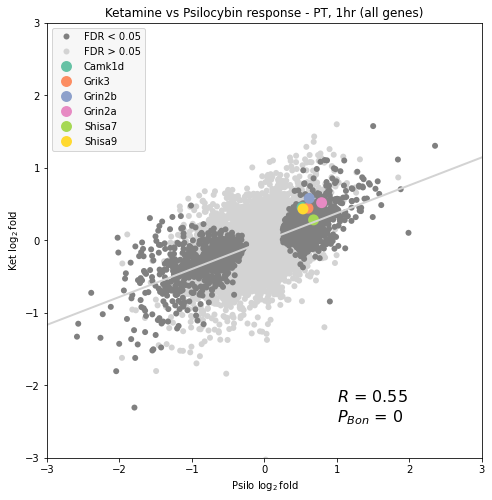

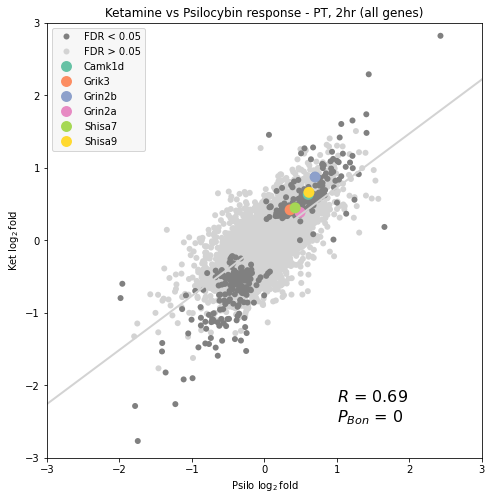

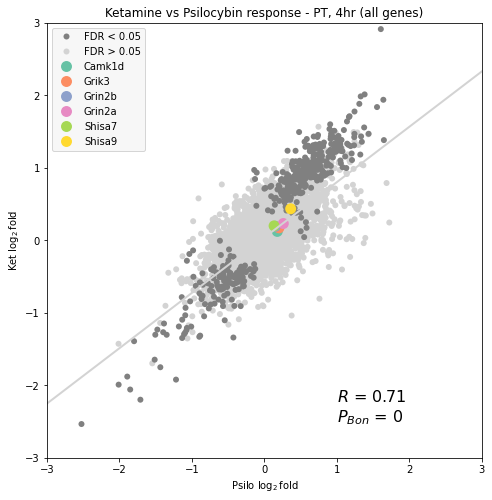

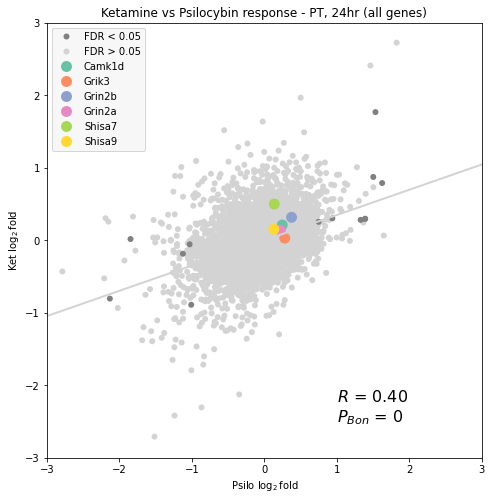

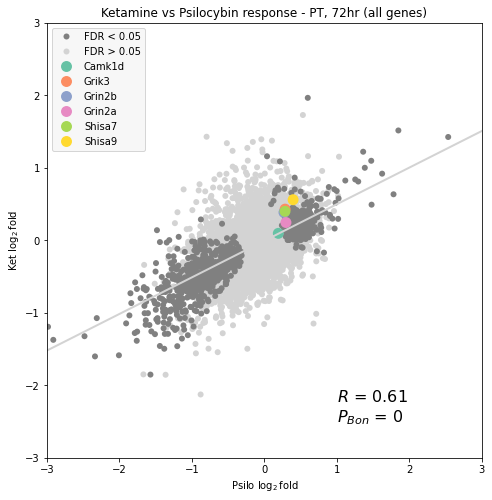

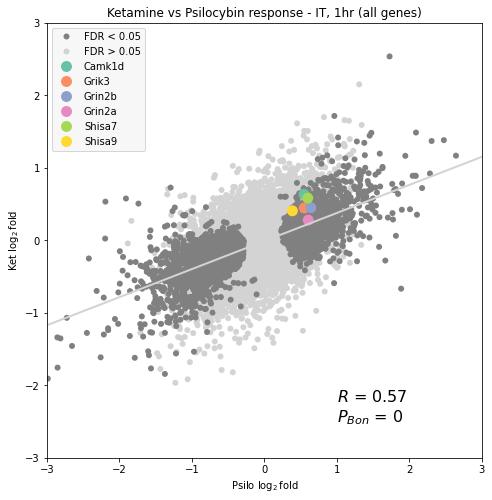

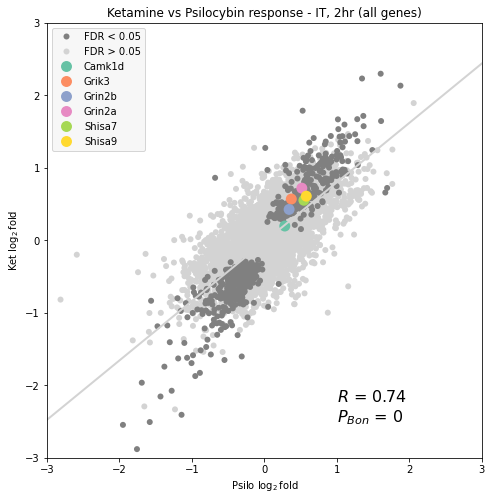

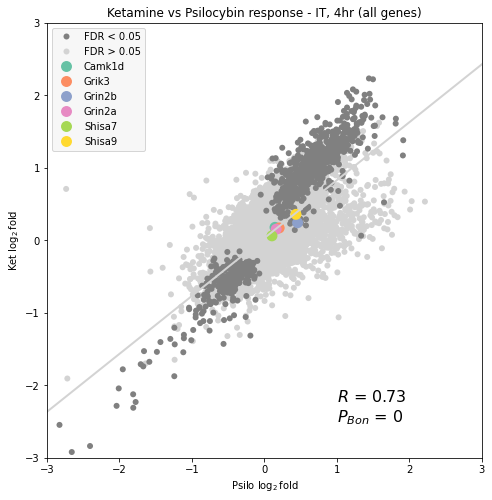

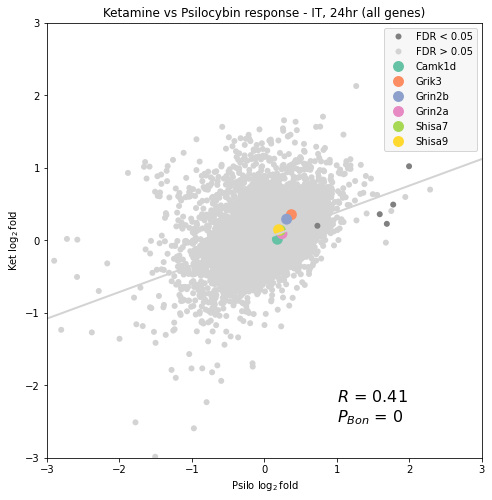

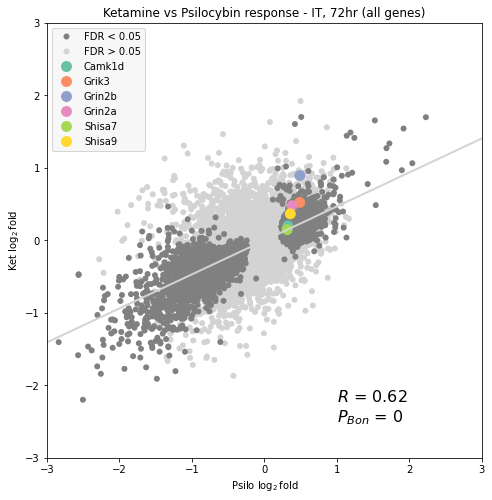

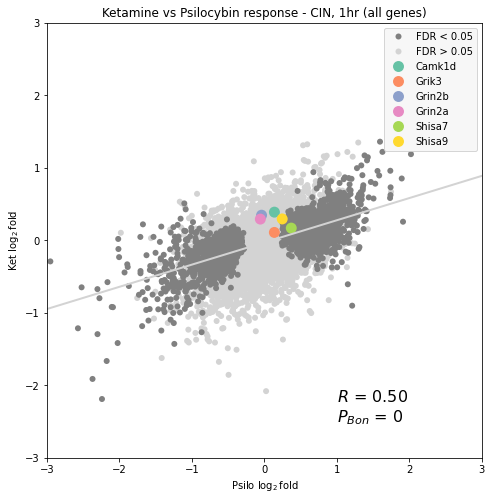

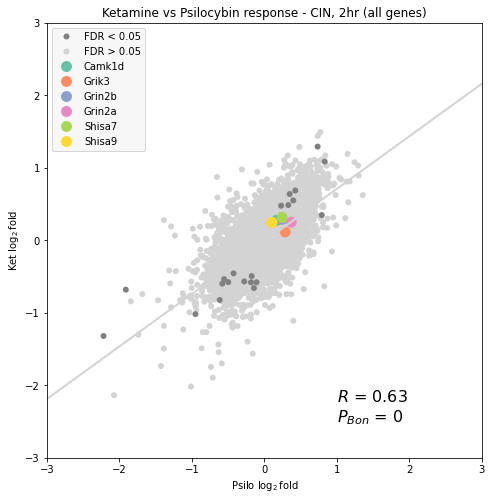

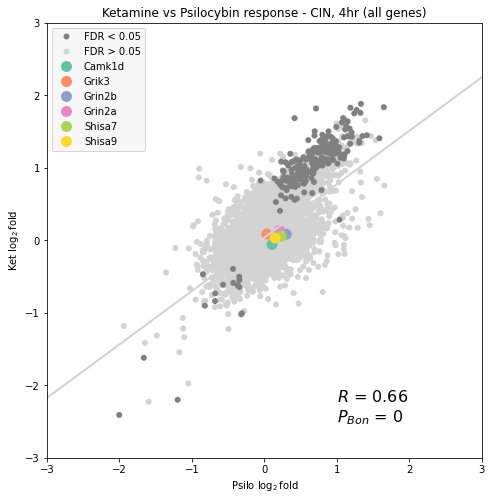

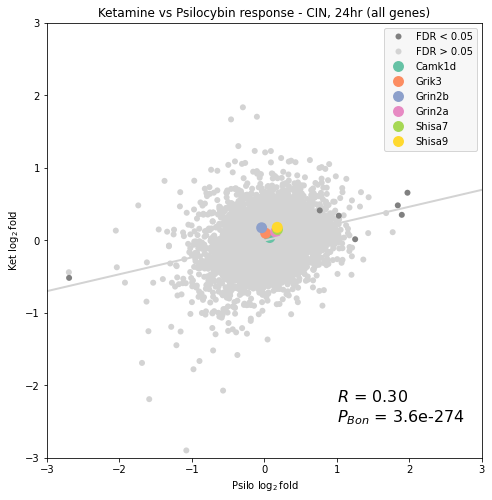

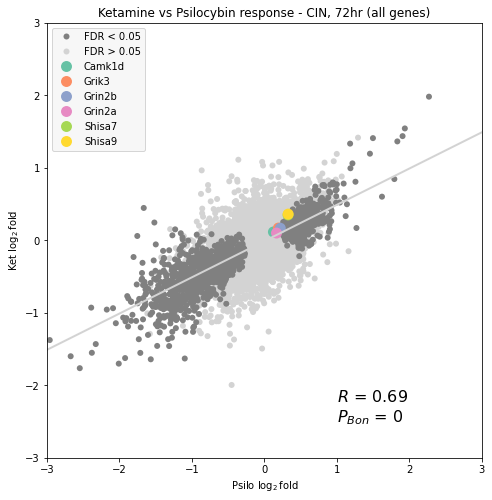

In [21]:
def plot_interdrug_scatter(data, celltype, time, important_genes=[]):
    data['is_significant'] = (data['FDR_psilo'] < 0.05) | (data['FDR_ket'] < 0.05)
    data = data.sort_values('is_significant')
    fig, ax = plt.subplots(figsize=(8,8))
    
    sns.scatterplot(
        data=data, x='logFC_psilo', y='logFC_ket',
        hue='is_significant', palette=['grey','lightgrey'], hue_order=[True,False],
        linewidth=0,
        ax = ax
    )
    
    regression_x = data['logFC_psilo'] 
    regression_y = data['logFC_ket'] 
    
    regression_res = scipystats.linregress(regression_x, regression_y)
    correlation, p_value = scipystats.pearsonr(regression_x, regression_y)
    
    # pre-hoc bonferroni correction
    p_value = min(1.0, p_value*15)
    ax.text(1,-2.5, f'$R$ = {correlation:.2f}\n$P_{{Bon}}$ = {p_value:.2g}', fontsize=16)
    ax.axline((0,regression_res.intercept), slope=regression_res.slope, c='lightgrey', linewidth=2)
    
    label_data = data[data['gene_name'].isin(important_genes)]
    sns.scatterplot(
        data=label_data,
        x='logFC_psilo', y='logFC_ket',
        hue='gene_name', palette='Set2', linewidth=0, s=120,
        ax=ax
    )
    
    ax.set_title(f'Ketamine vs Psilocybin response - {celltype}, {time}hr (all genes)')
    ax.set(xlabel='Psilo $\log_2$fold', ylabel='Ket $\log_2$fold',
          xlim=(-3,3), ylim=(-3,3))
    ax.set_box_aspect(1.0)
    ax.legend(handles=ax.legend().legendHandles, 
              labels=['FDR < 0.05', 'FDR > 0.05']+important_genes, 
              title=None, 
              facecolor='whitesmoke')
    return fig
    
    
for name, time in itertools.product(celltype_paths.keys(), scatter_times):
    df = pseudobulk_de_dataframes[(pseudobulk_de_dataframes['celltype'] == name) &
                                  (pseudobulk_de_dataframes['time'] == time)]
    psilo_degs = df[df['drug'] == 'Psilo']
    ket_degs = df[df['drug'] == 'Ket']
    df = psilo_degs.merge(ket_degs, on=['gene_name','celltype','time'], how='inner', suffixes=('_psilo','_ket'))
    # df = df[(df['FDR_psilo'] < 0.05) | (df['FDR_ket'] < 0.05)]
    
    genes_to_label = ['Camk1d','Grik3','Grin2b','Grin2a','Shisa7','Shisa9']
    fig = plot_interdrug_scatter(df, name, time, important_genes=genes_to_label)
    plt.show(fig)
    fig.savefig(f"{this_figure_dir}/scatter_{name}_{time}h_all_genes.png", dpi=600)
    fig.savefig(f"{this_figure_dir}/scatter_{name}_{time}h_all_genes.pdf", dpi=600)
#     break